In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from experiment import Experiment
from utils import PlaceFields, get_flanks, get_loc_batch
from agent import Agent
from tqdm import tqdm

In [2]:
def eval_position(agent, coords, grid_cells, size=4096):
    losses = list()
    for _ in range(size // 256):
        x, y = get_loc_batch(coords, grid_cells, bs=256)
        x = agent.actor(x)[1]
        loss = torch.sum((x - y)**2).detach().cpu().numpy()
        losses.append(loss)
    return np.mean(losses)

def print_stats(w):
    print("min   |max  |mean |std  |shape")
    print(f"{w.min():.03f}|{w.max():.03f}|{w.mean():.03f}|{w.std():.03f}|{w.shape}")

In [3]:
hidden = 500
lr_a = 3e-4
wd_l1 = 1e-5
wd_l2 = 1e-7
hidden_penalty = 2e-2

In [4]:
exp = Experiment('test', wd_l1=wd_l1, wd_l2=wd_l2, hidden_penalty=hidden_penalty, actor_hidden=hidden, lr_a=lr_a)
exp.compile_grid_cells(1)

In [5]:
losses = exp.fit_positions()

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [18:22<00:00, 45.33it/s]


In [6]:
net = exp.agent.actor
net.clamp_weights()

print_stats(net.b1)
print_stats(net.w1)
print_stats(net.w1.sum(1))

min   |max  |mean |std  |shape
-2.800|2.975|0.944|1.794|torch.Size([500])
min   |max  |mean |std  |shape
0.000|6.114|0.002|0.034|torch.Size([500, 1000])
min   |max  |mean |std  |shape
0.000|14.265|1.901|3.704|torch.Size([500])


Position loss: 0.630


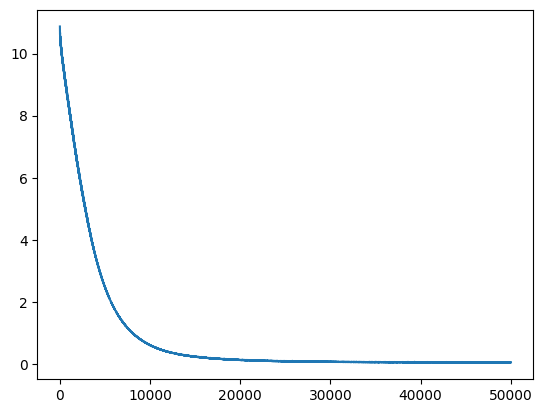

In [7]:
print(f"Position loss: {eval_position(exp.agent, exp.coords, exp.grid_cells):.03f}")
plt.plot(losses)
plt.show()

In [8]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([-3.5900,  3.7024, -3.8673,  3.9954,  4.0951,  3.6528, -3.7230,  3.7473,
        -3.9327,  4.0691])


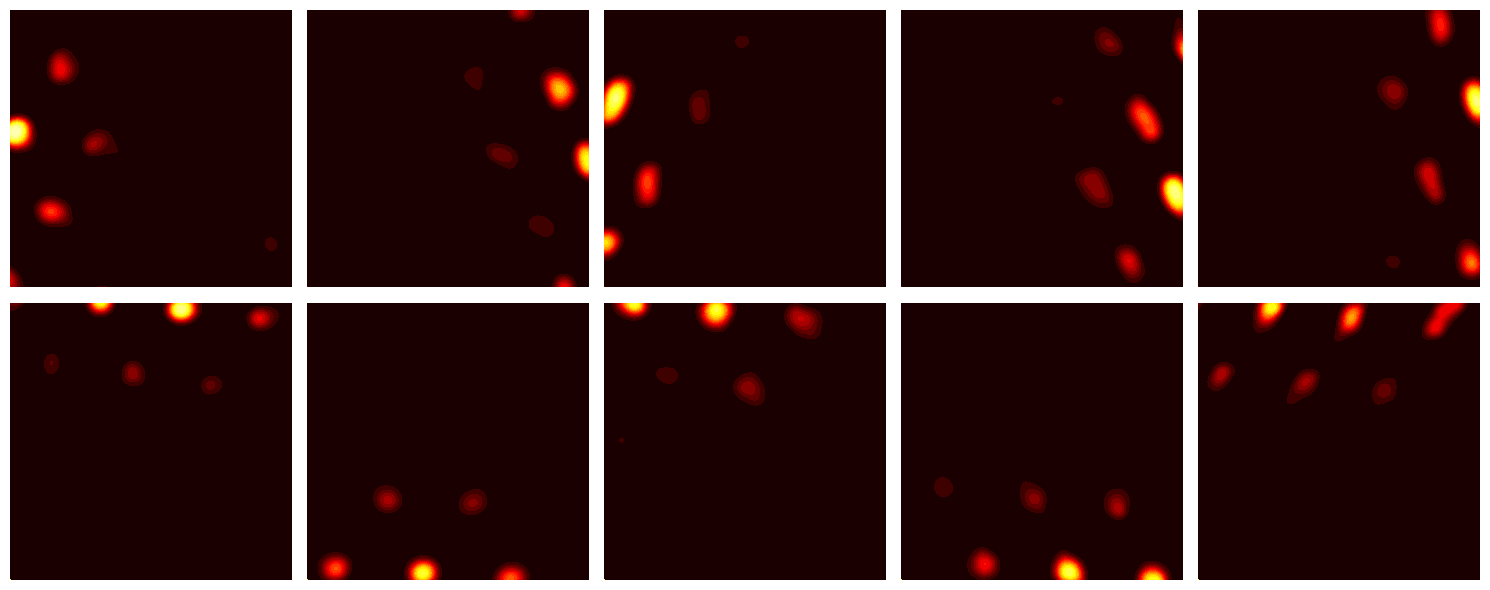

In [9]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = net.lin1(exp.grid_cells).permute((-1, 0, 1)).detach().cpu().numpy()
# Small hack to ensure the scale of every plot is the same
hidden[:,0,0] = hidden.max()
hidden[:,0,1] = hidden.min()

idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

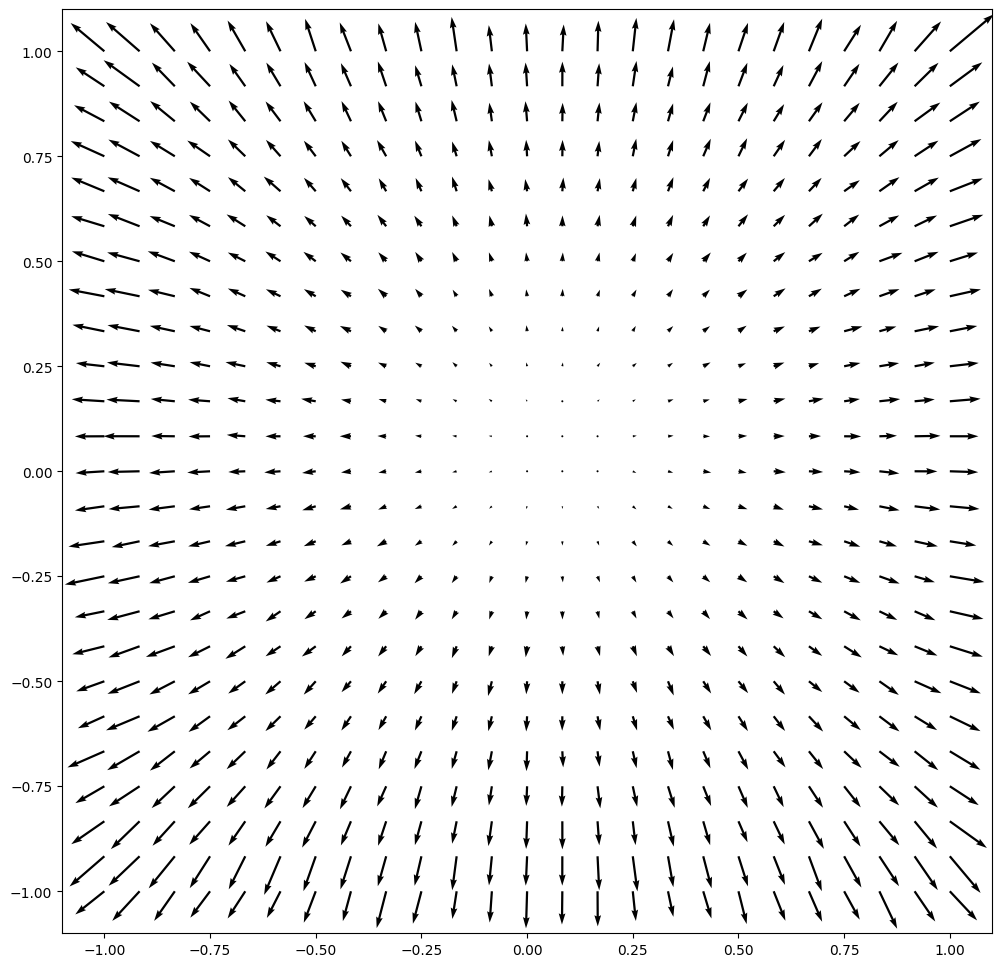

In [10]:
xy = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xy, xy)

plt.figure(figsize=(12, 12))
plt.quiver(X, Y, *net.lin2(net.lin1(exp.grid_cells))[::16,::16,2:].permute(-1, 0, 1).detach().cpu())
plt.show()

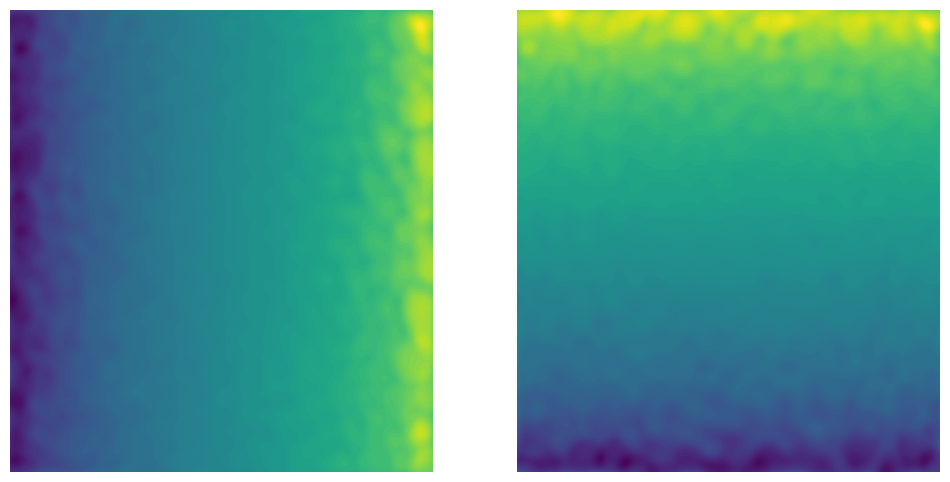

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.axis('off')
ax2.axis('off')
ax1.contourf(net.lin2(net.lin1(exp.grid_cells))[:,:,2].detach().cpu(), levels=100)
ax2.contourf(net.lin2(net.lin1(exp.grid_cells))[:,:,3].detach().cpu(), levels=100)
plt.show()

min   |max  |mean |std  |shape
-3.933|4.095|-0.023|2.259|torch.Size([2, 104])
min   |max  |mean |std  |shape
-1.803|2.334|0.009|0.214|torch.Size([2, 396])


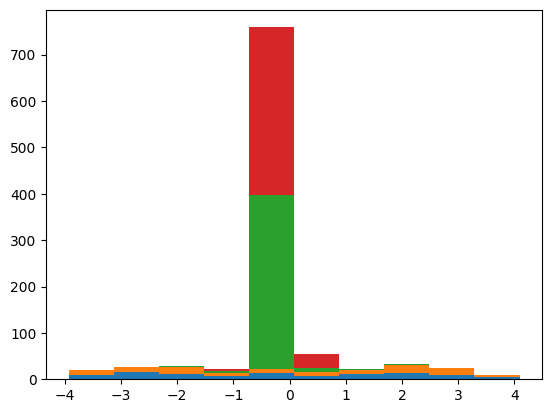

In [12]:
used = hidden.mean((1, 2)) > hidden.mean()# + hidden.mean((1, 2)).std() / 20

print_stats(net.lin2.weight[2:, used])
print_stats(net.lin2.weight[2:, ~used])

plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

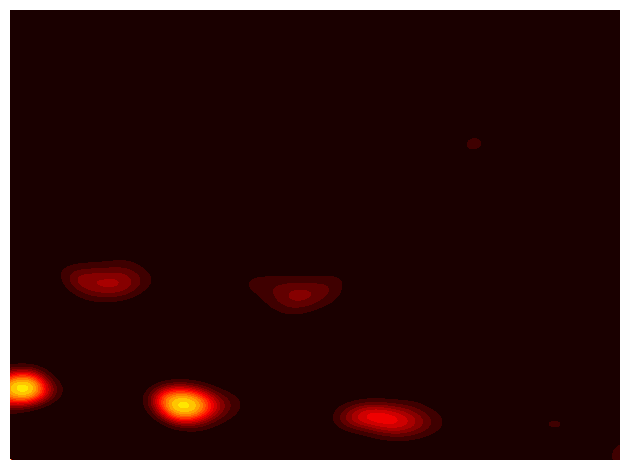

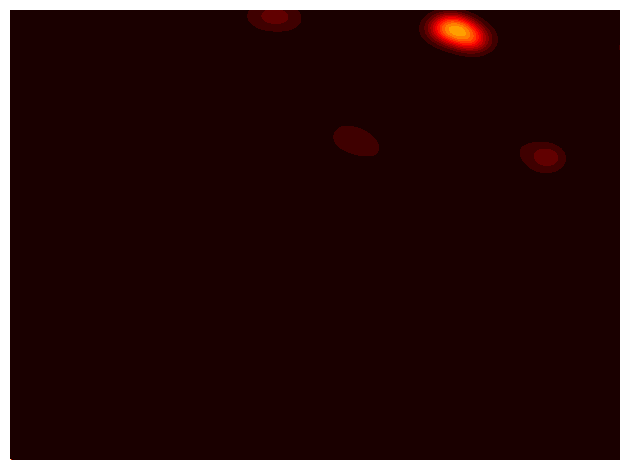

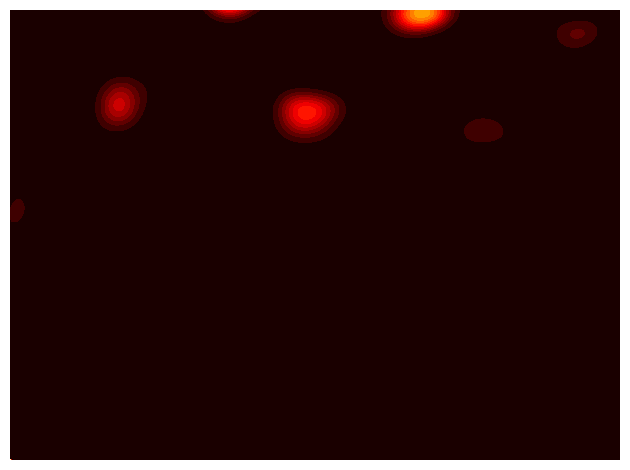

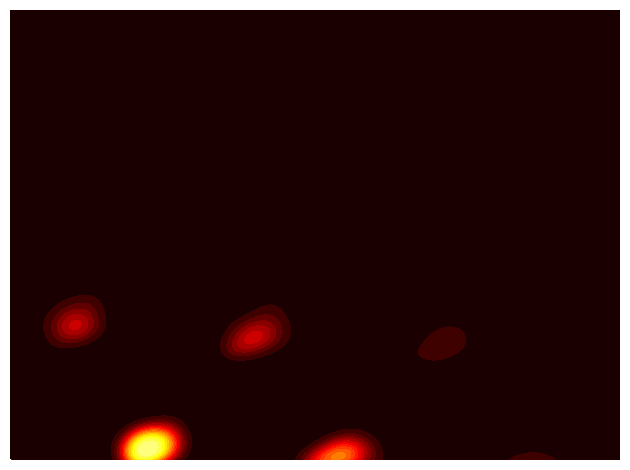

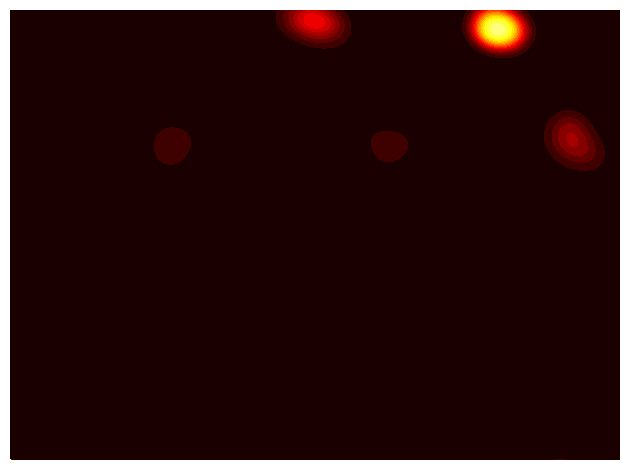

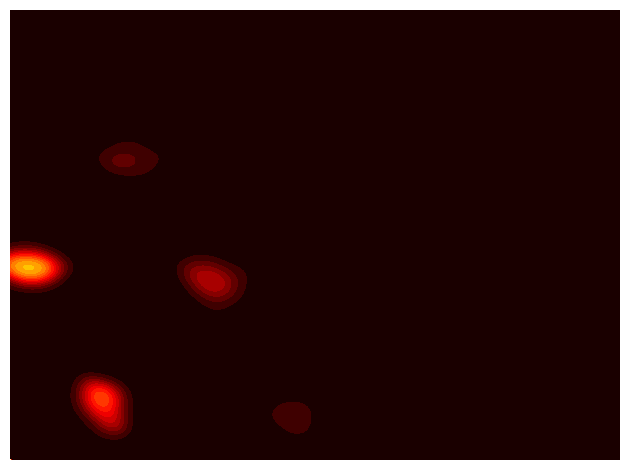

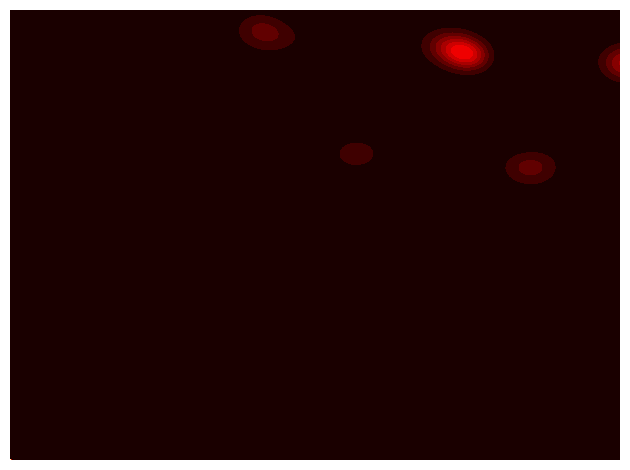

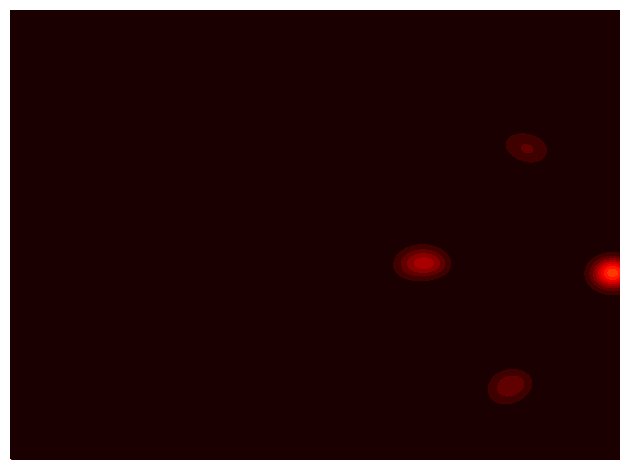

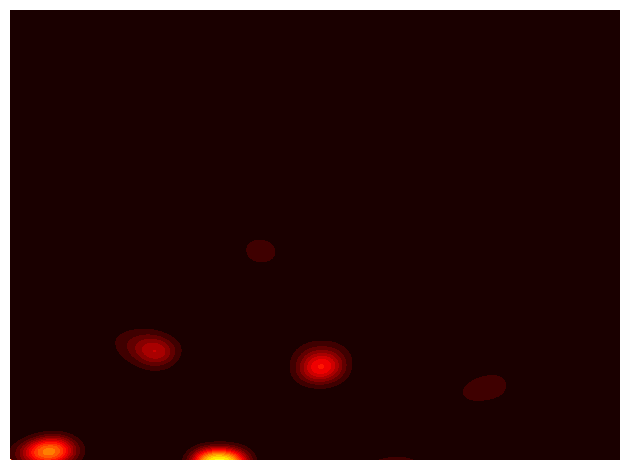

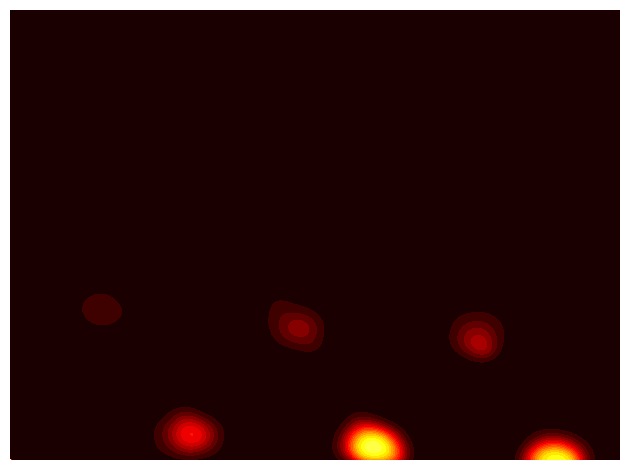

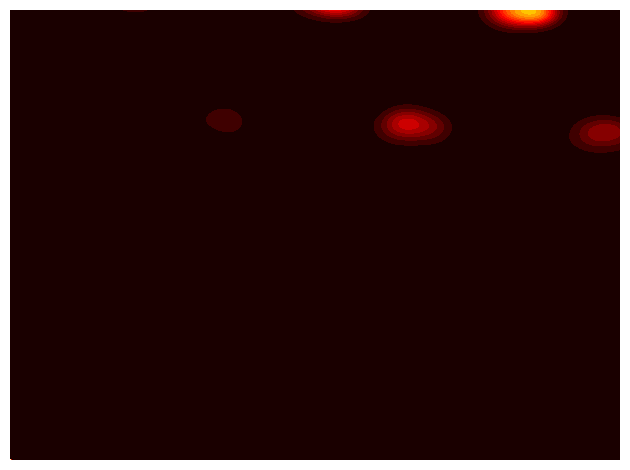

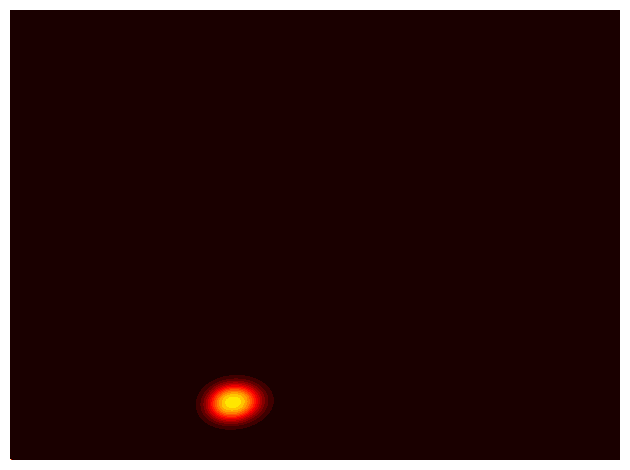

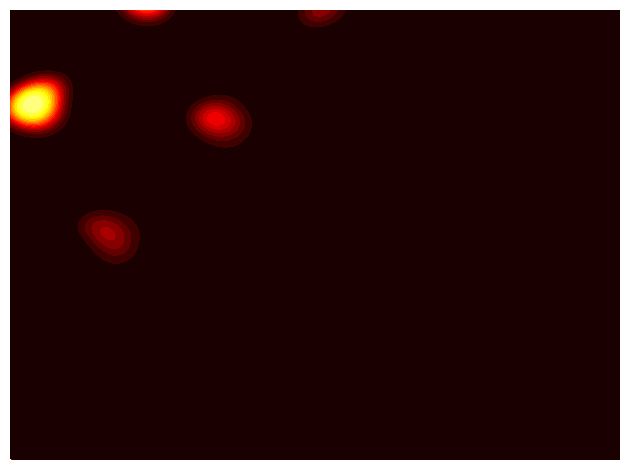

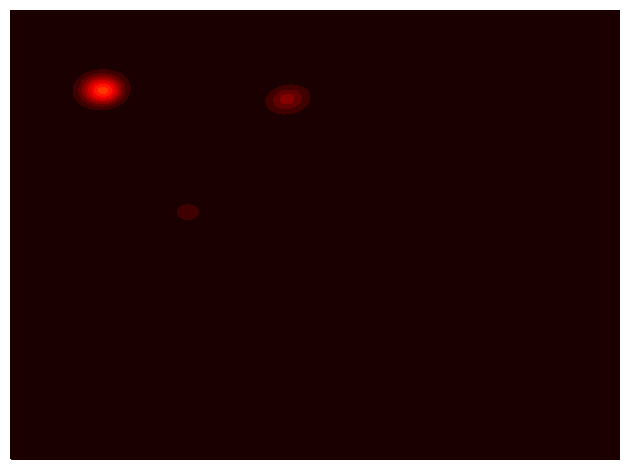

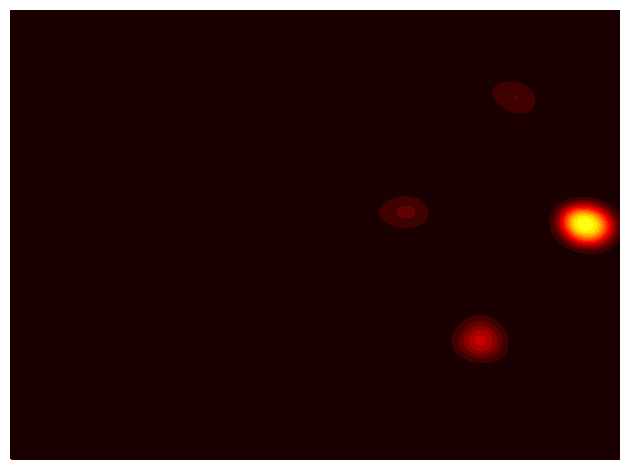

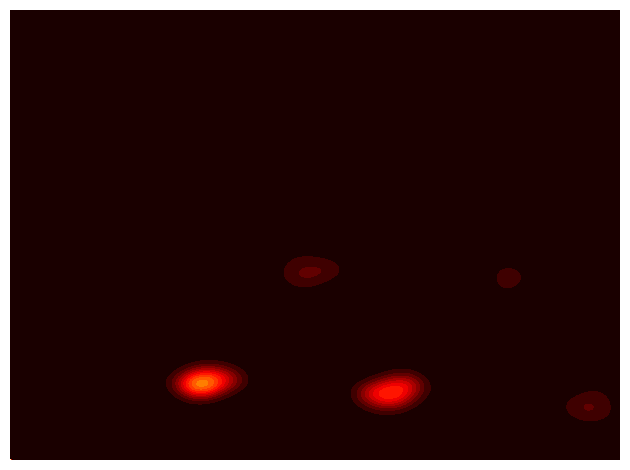

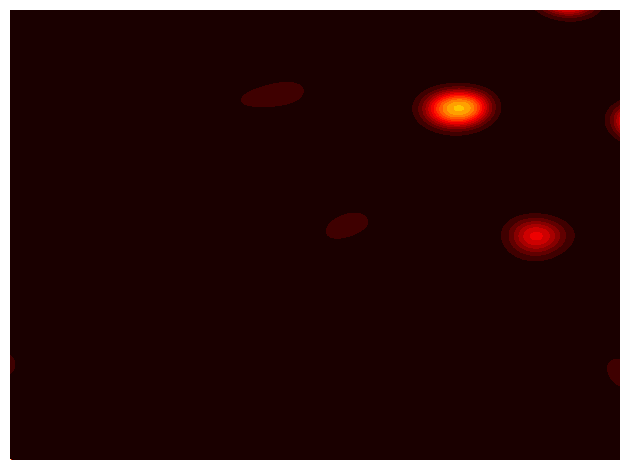

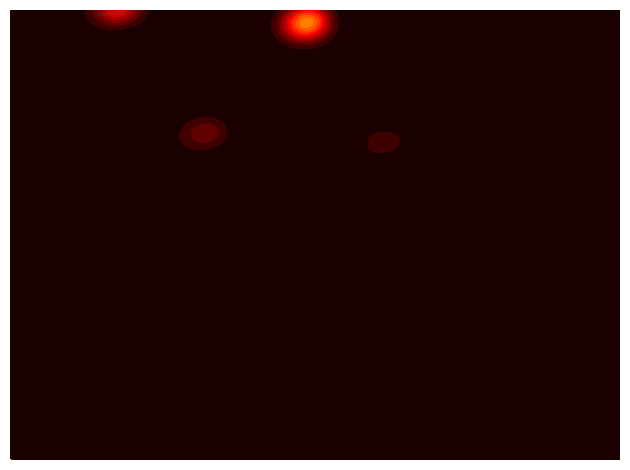

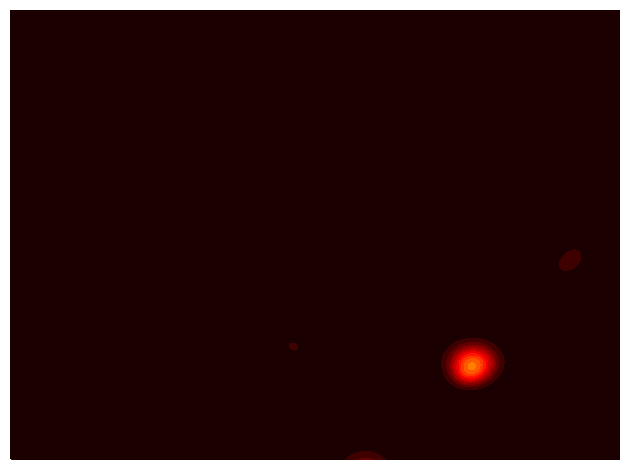

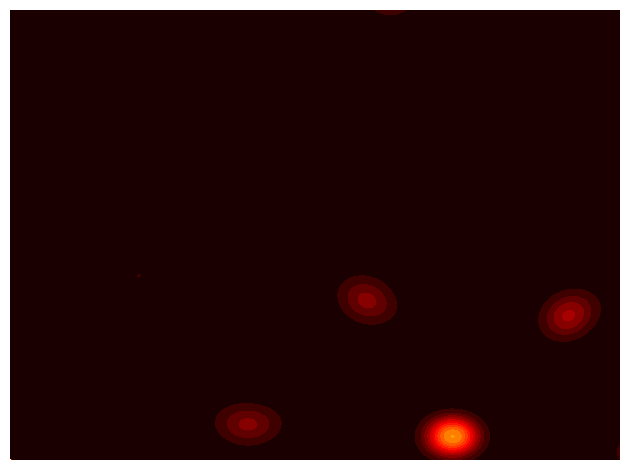

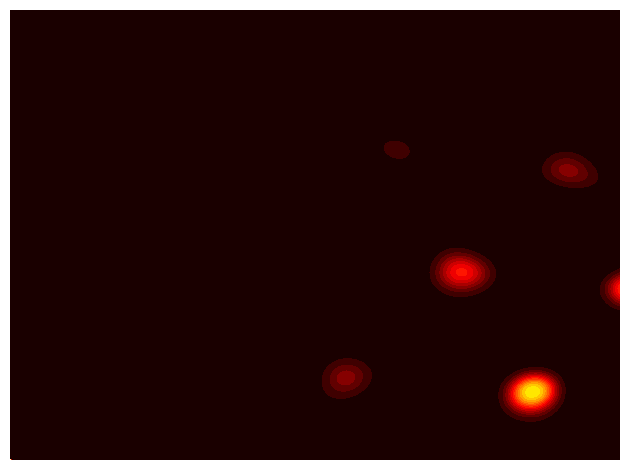

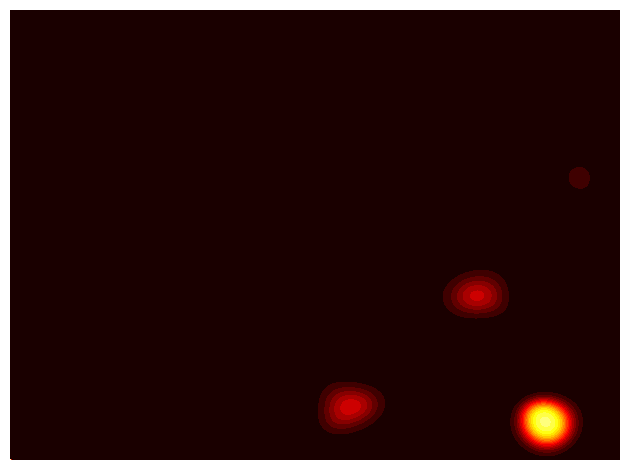

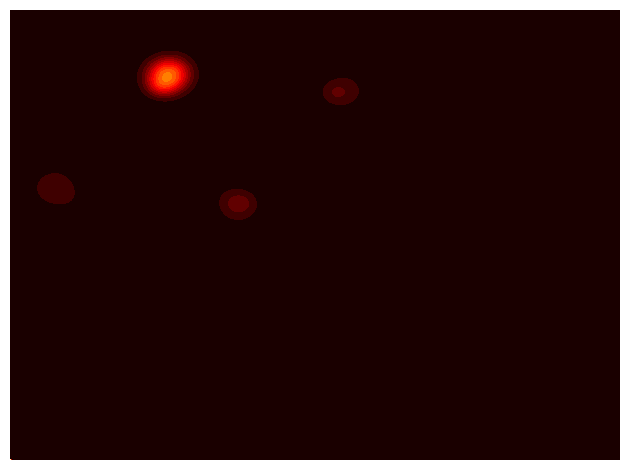

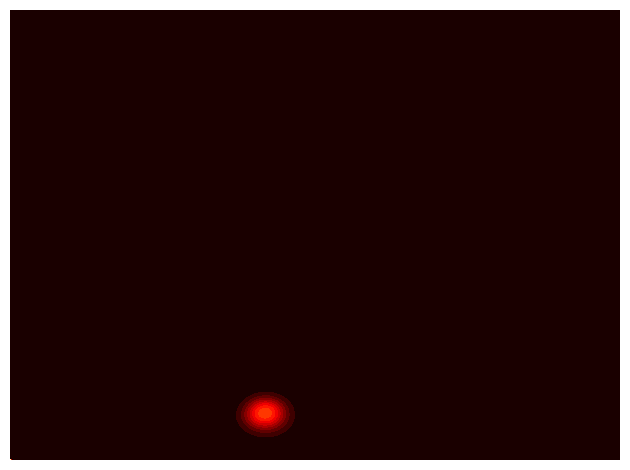

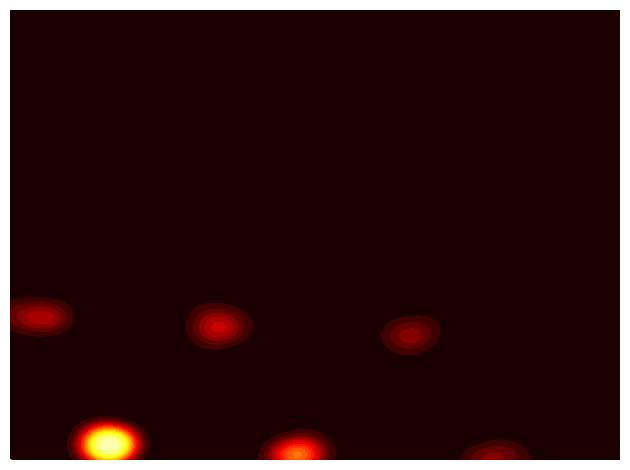

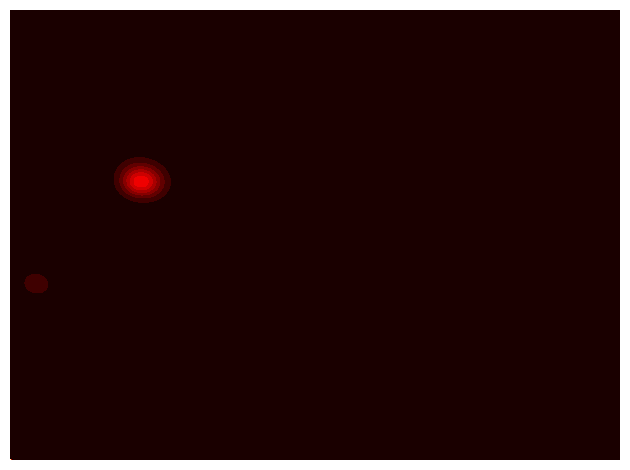

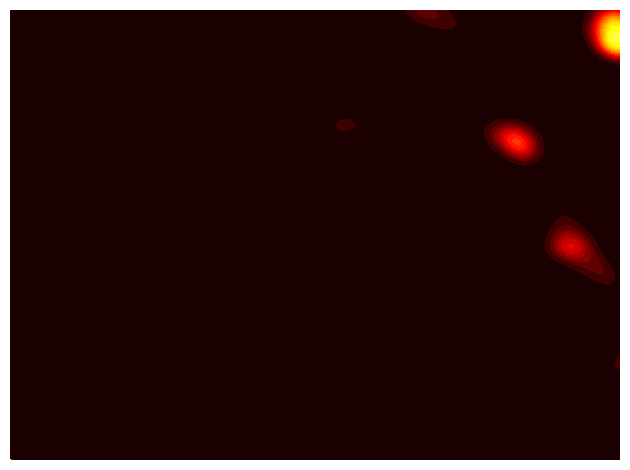

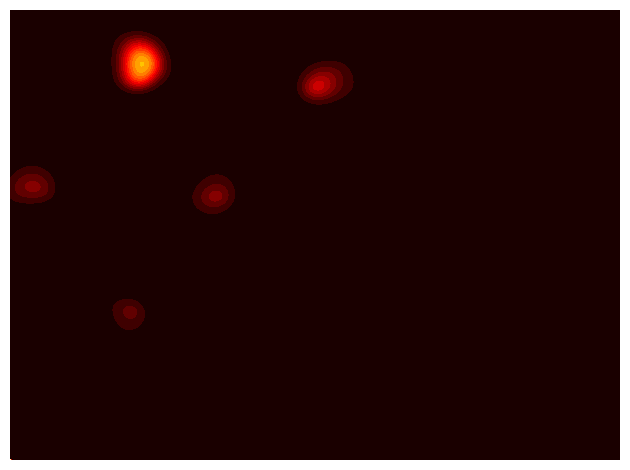

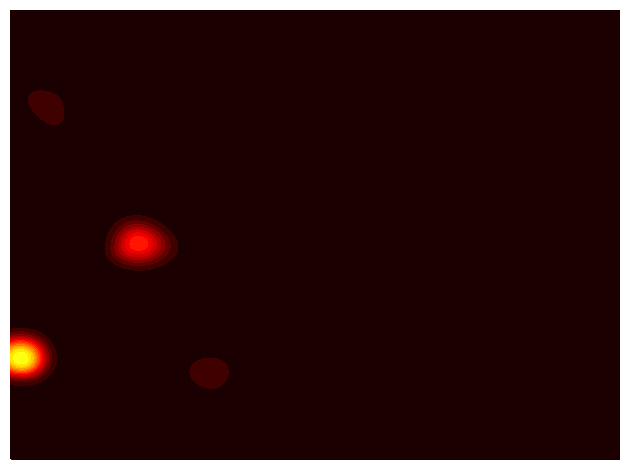

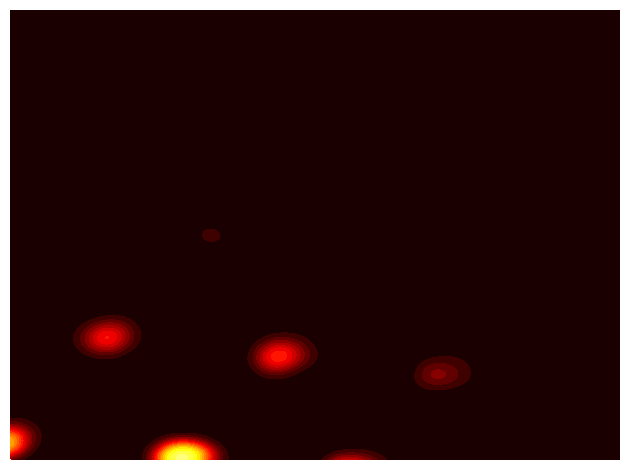

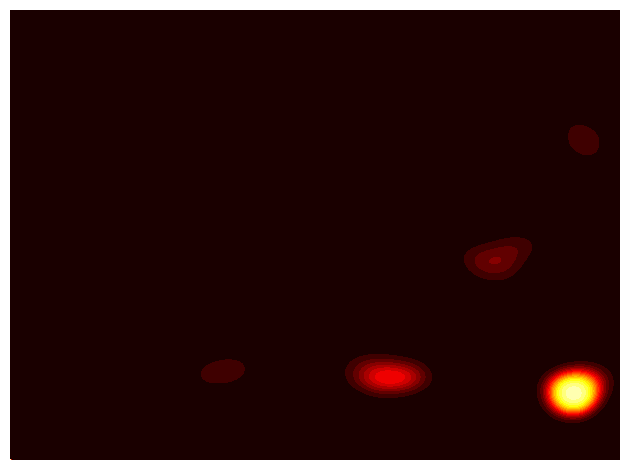

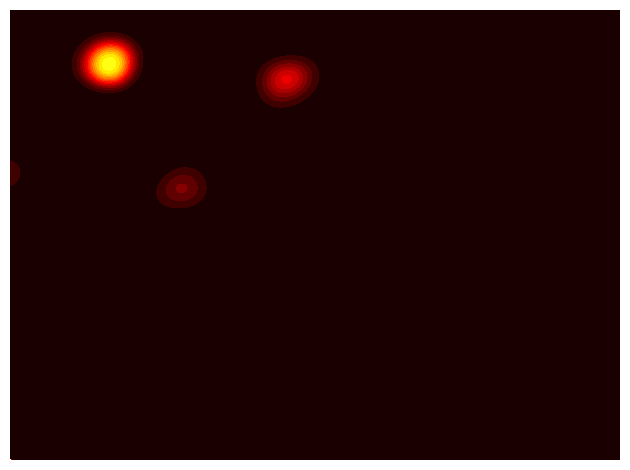

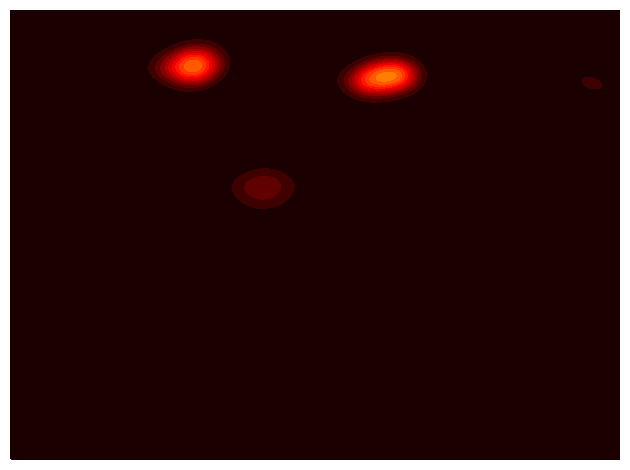

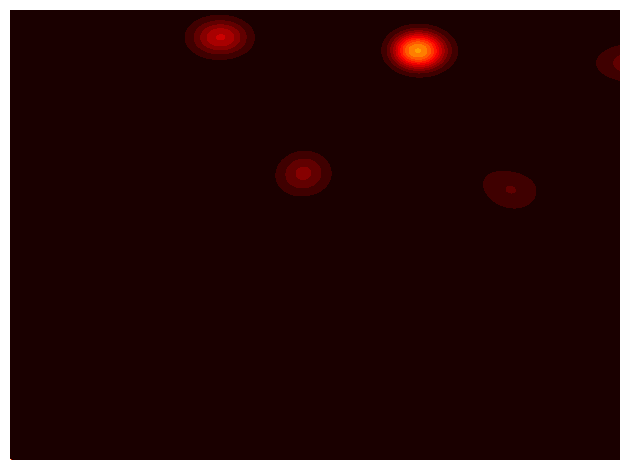

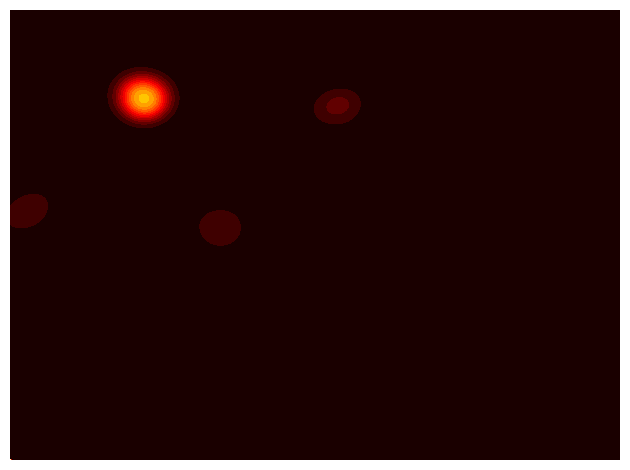

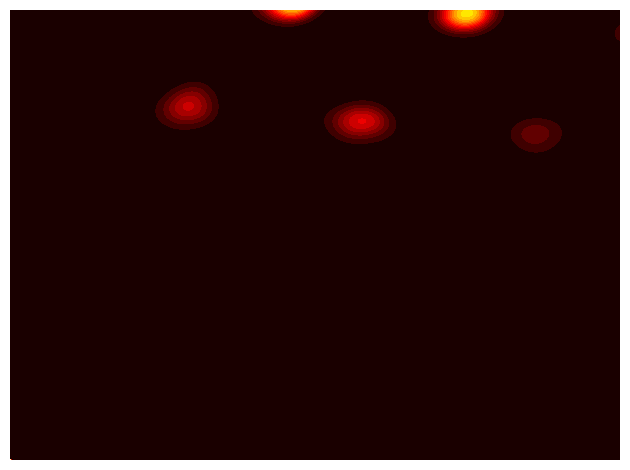

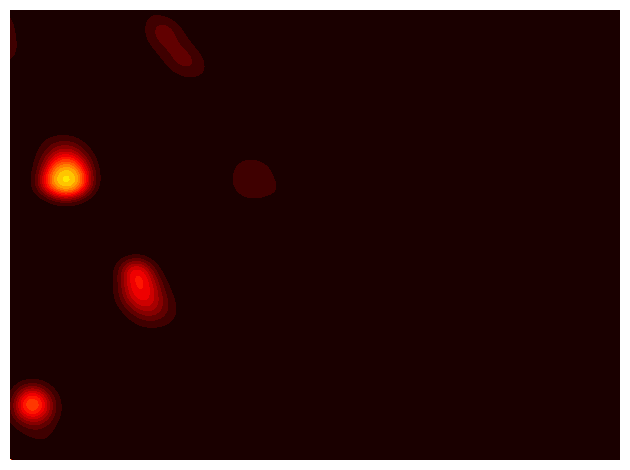

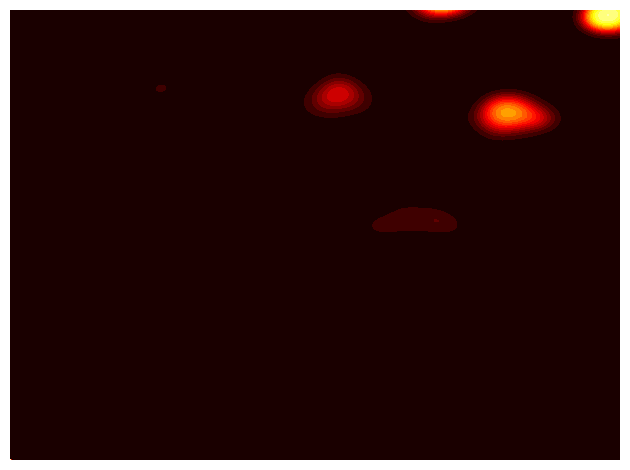

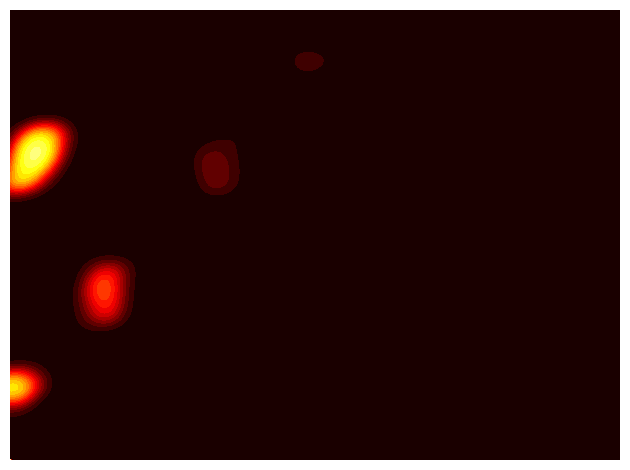

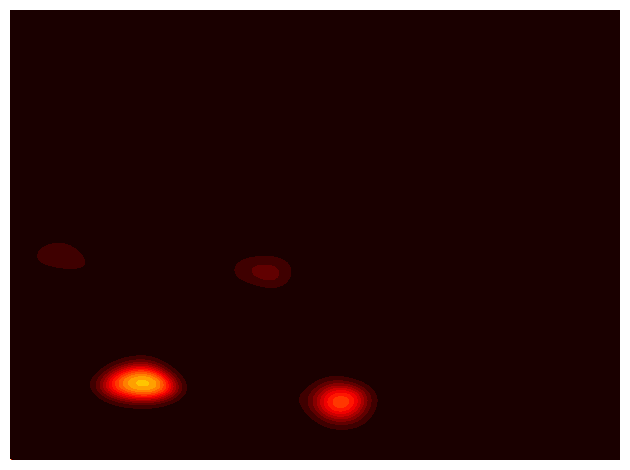

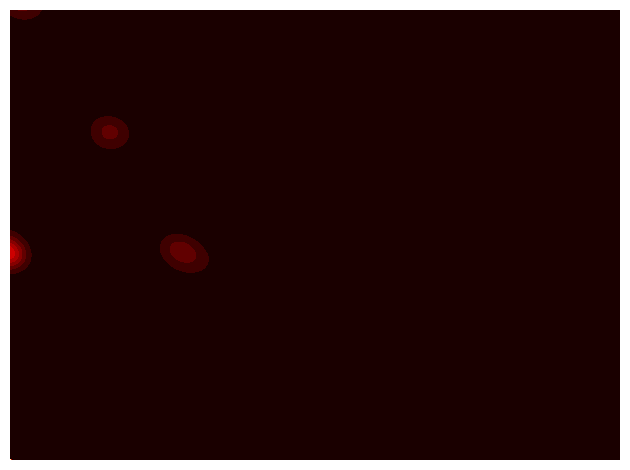

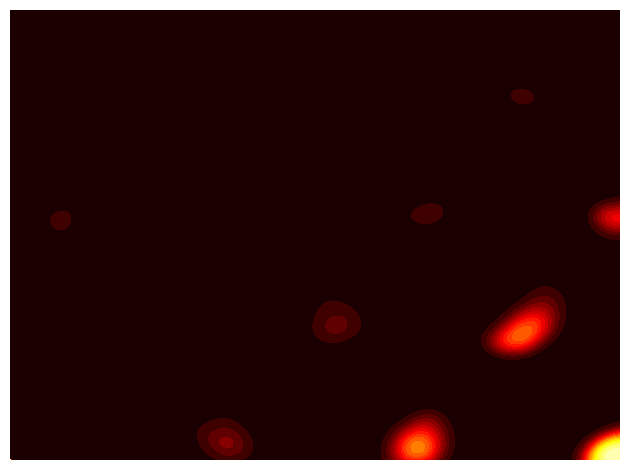

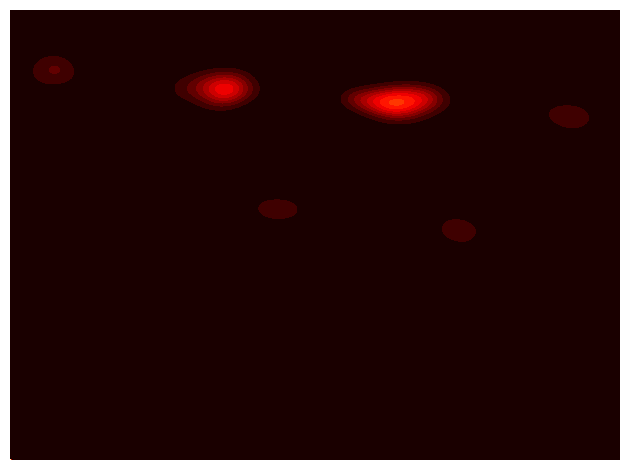

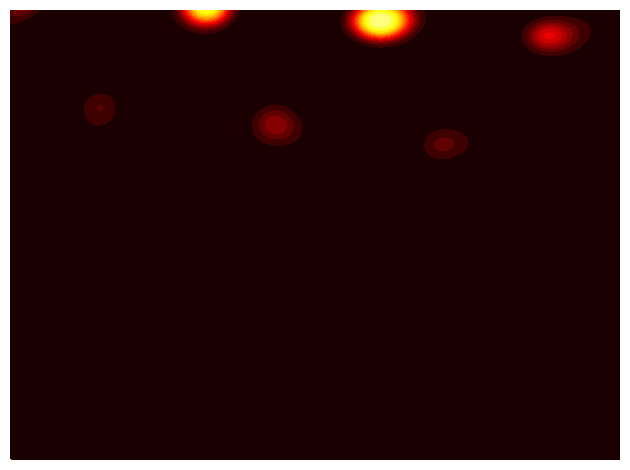

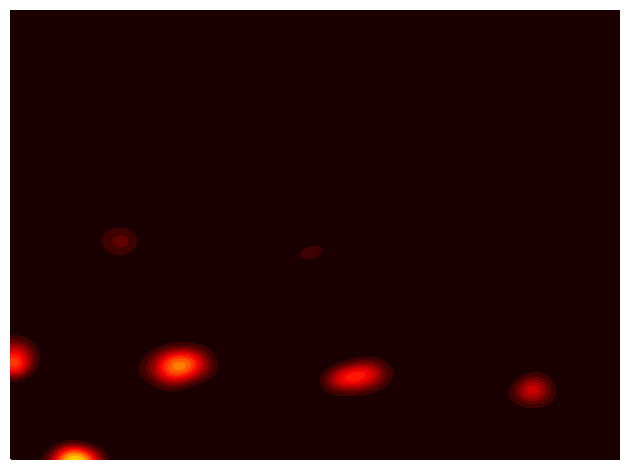

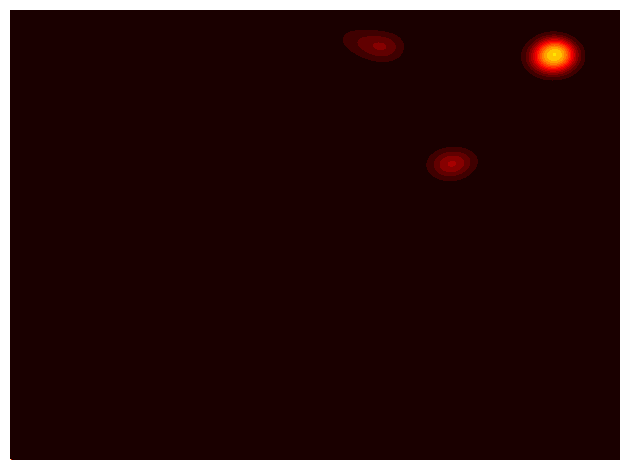

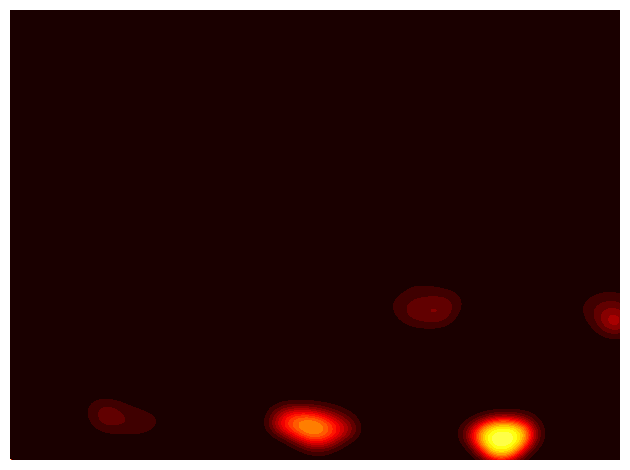

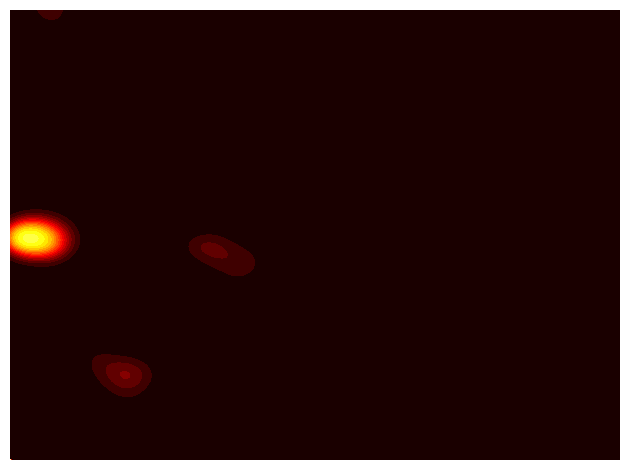

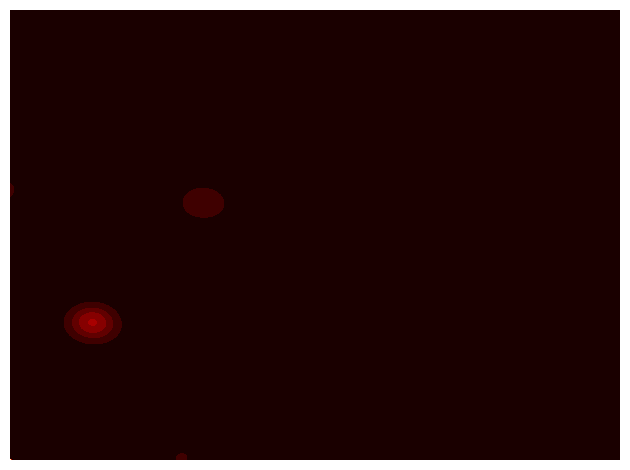

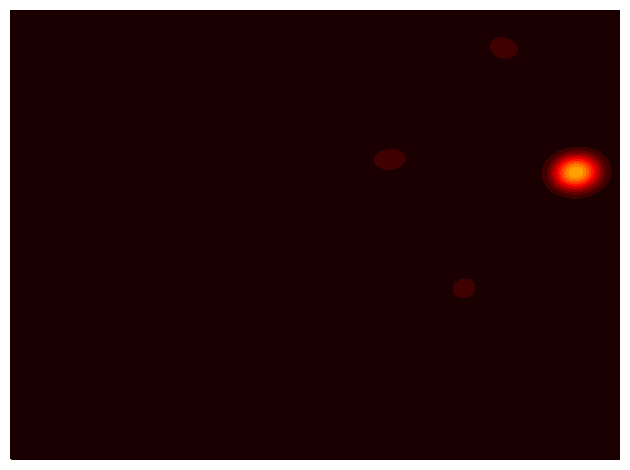

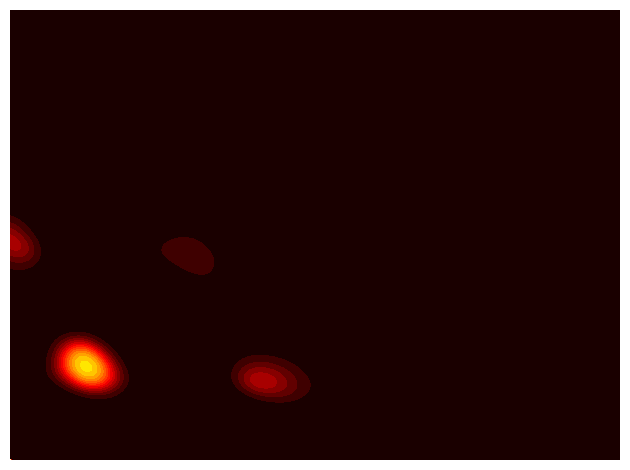

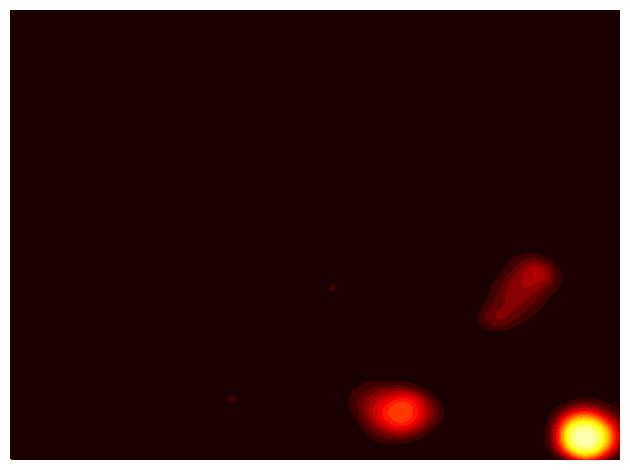

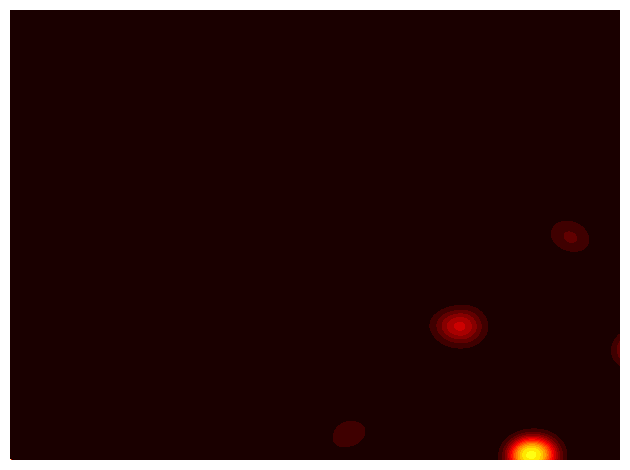

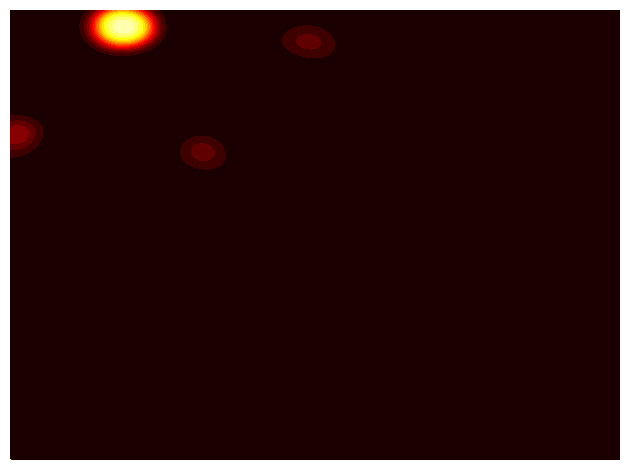

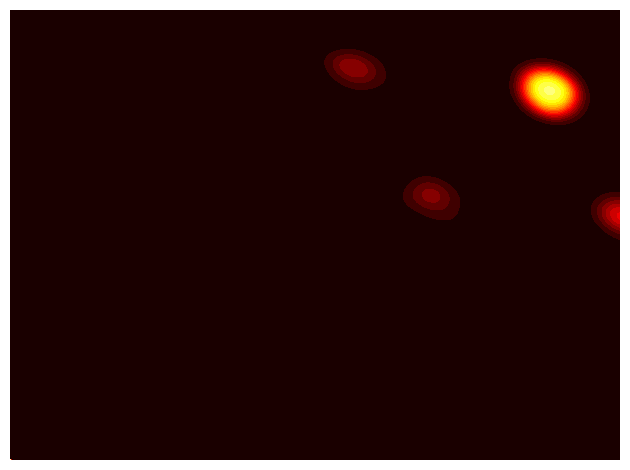

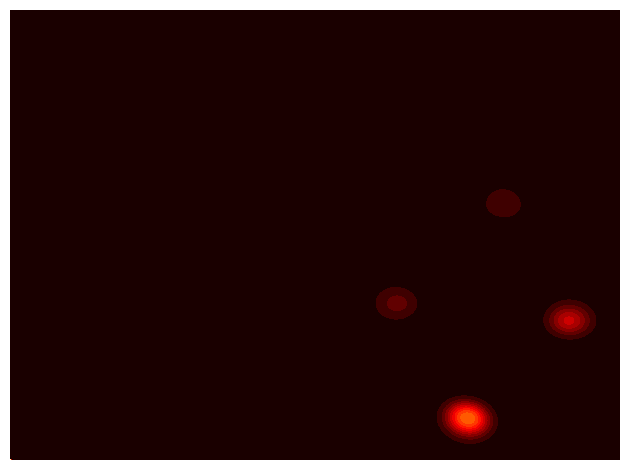

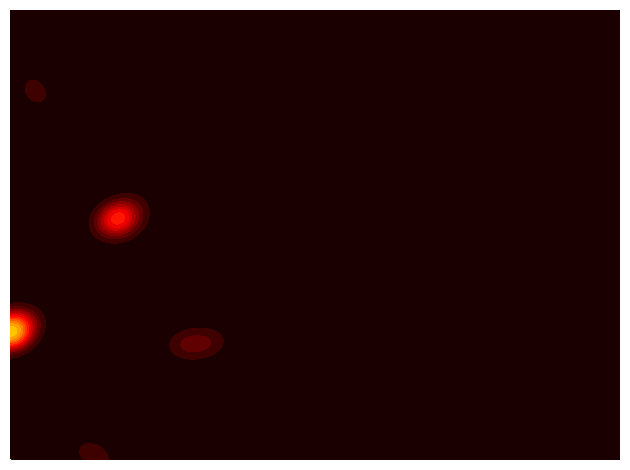

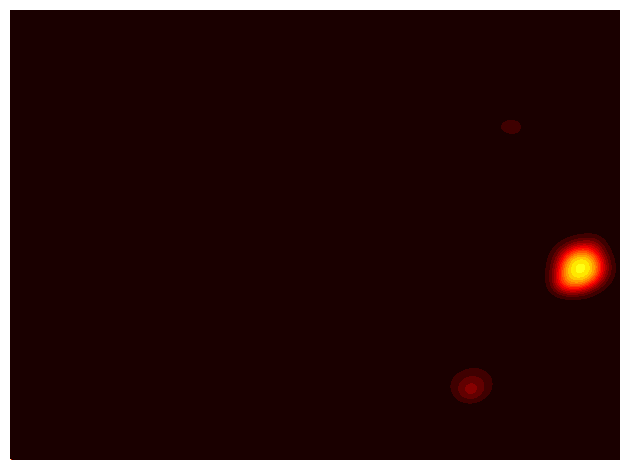

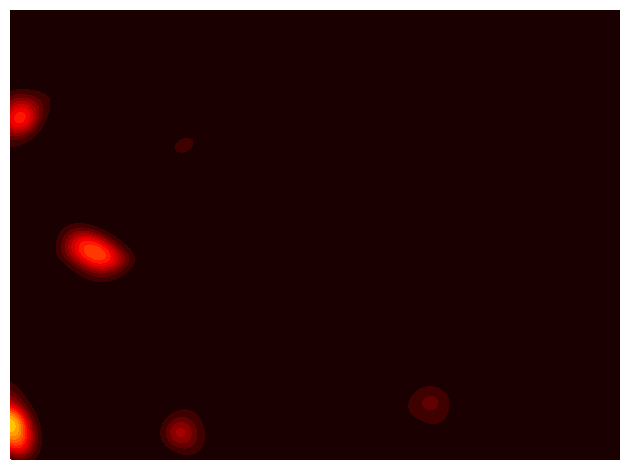

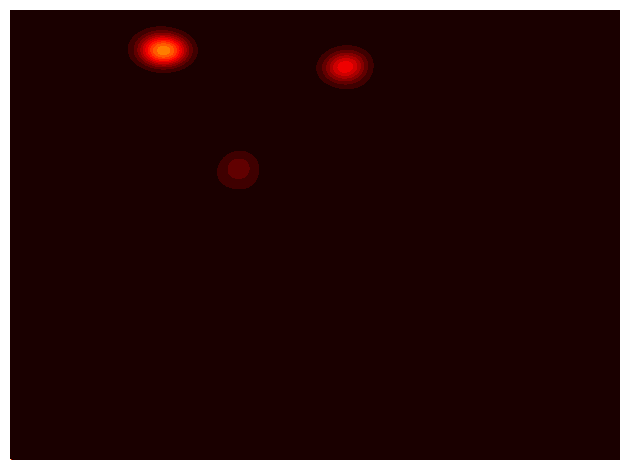

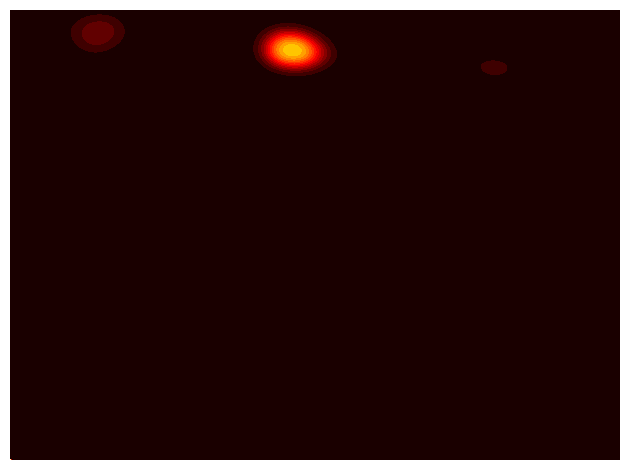

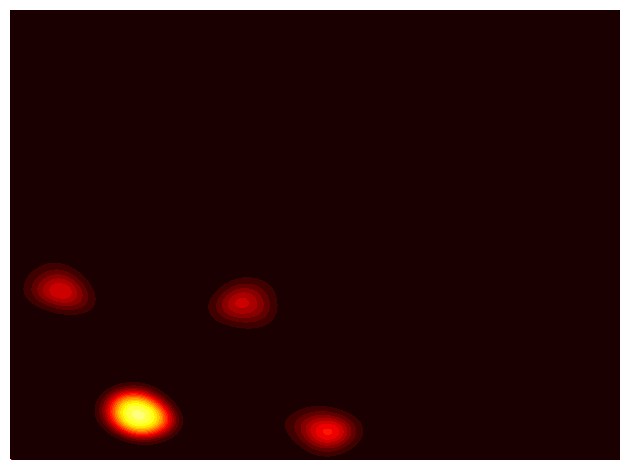

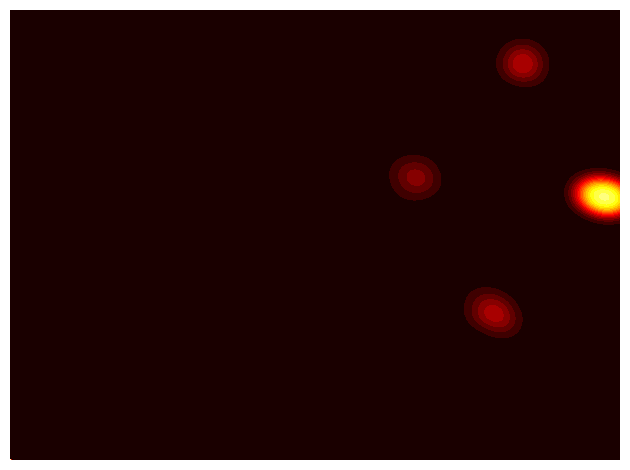

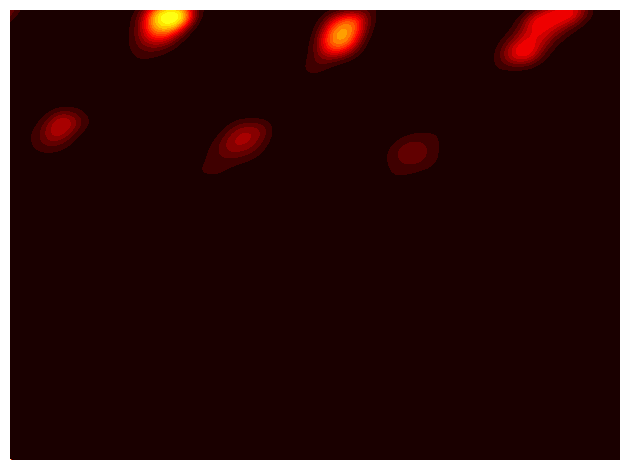

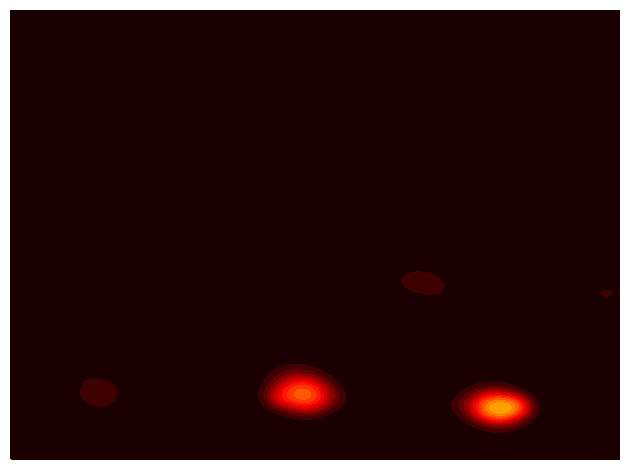

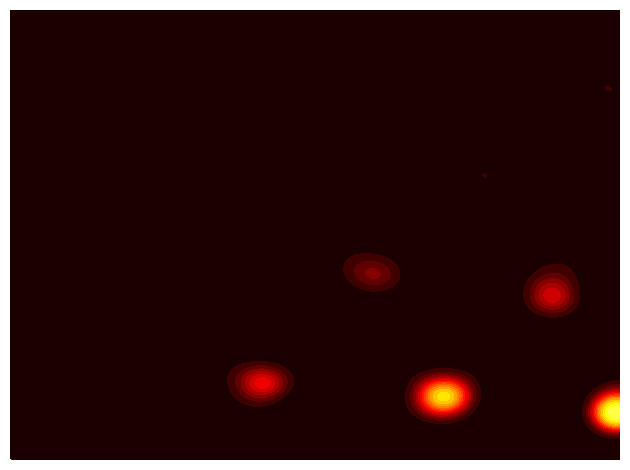

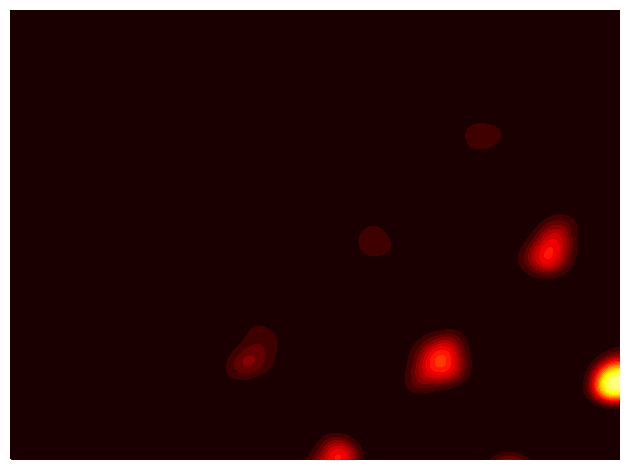

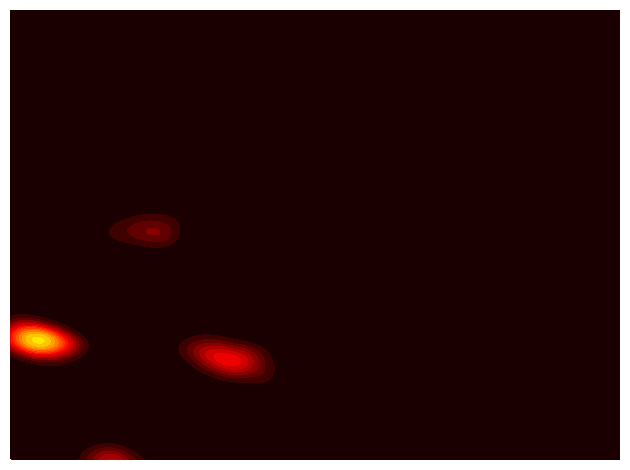

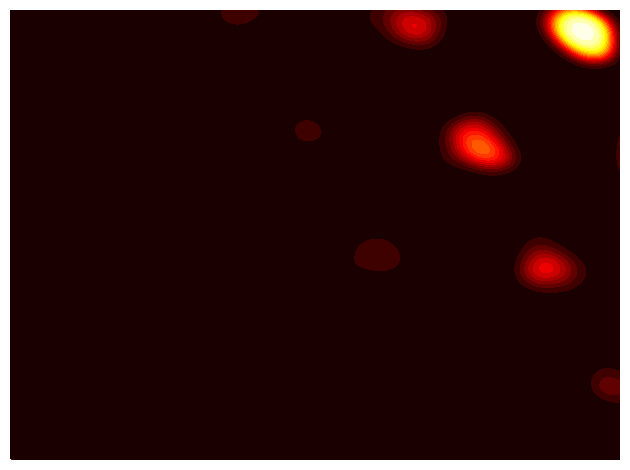

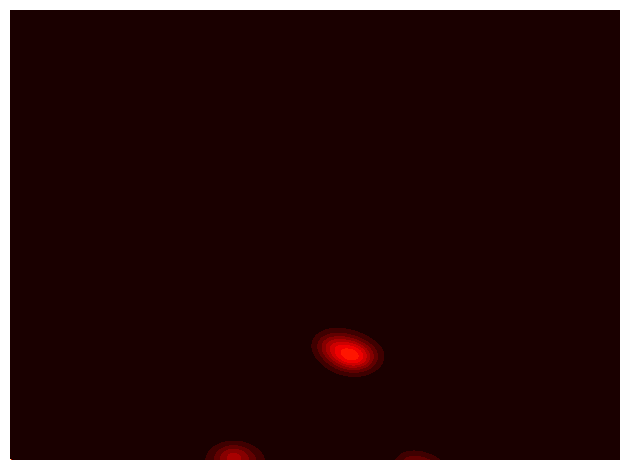

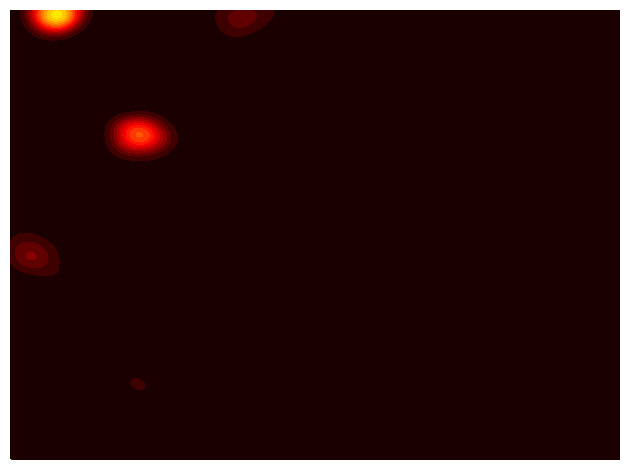

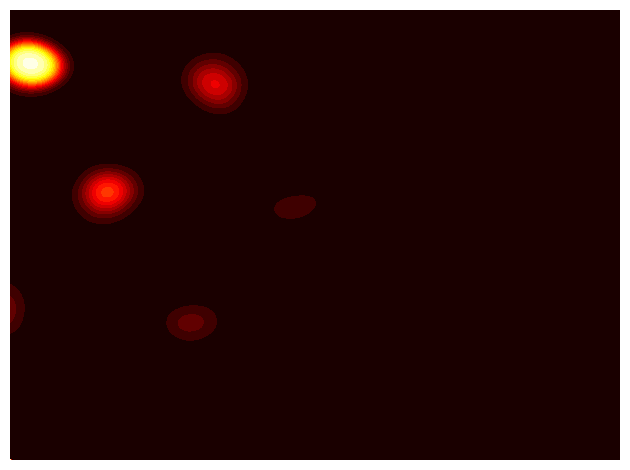

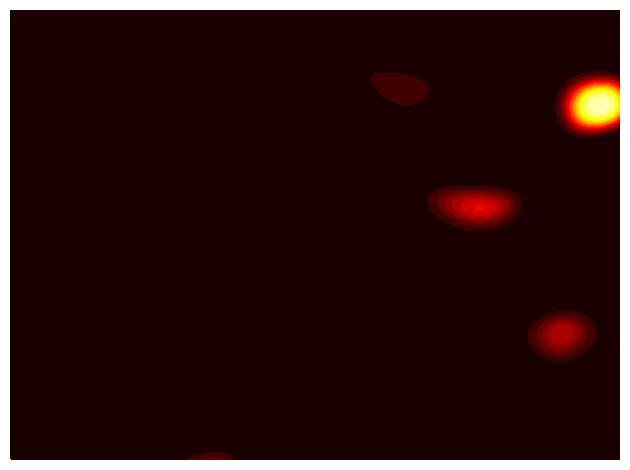

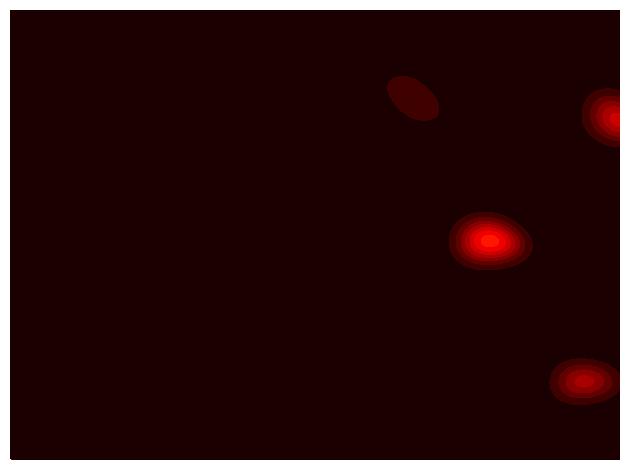

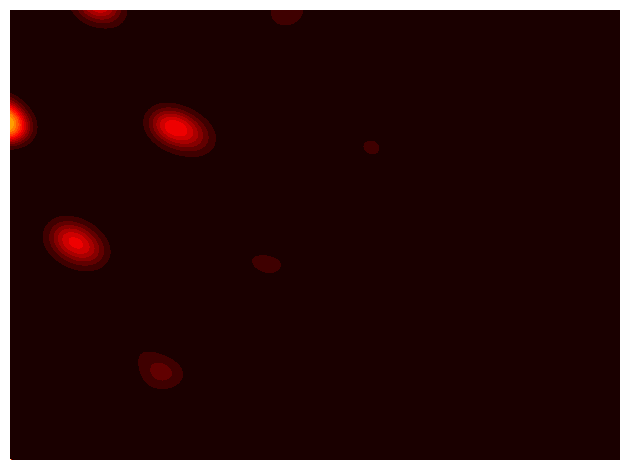

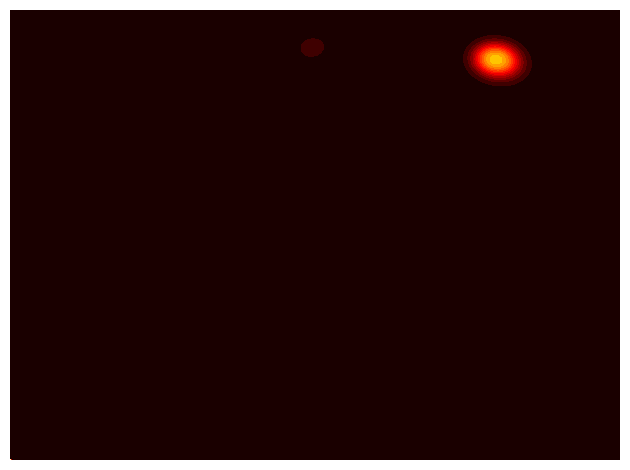

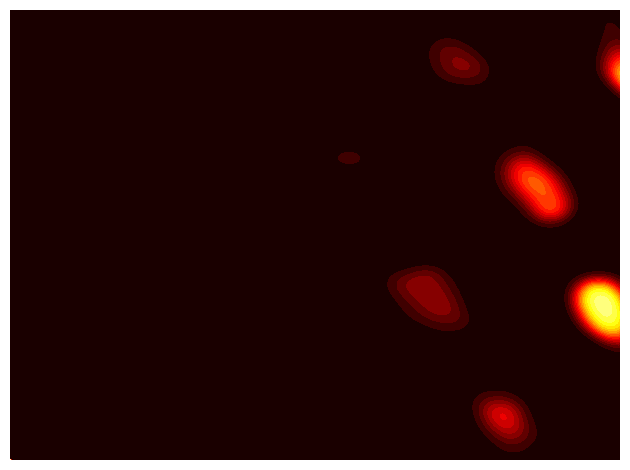

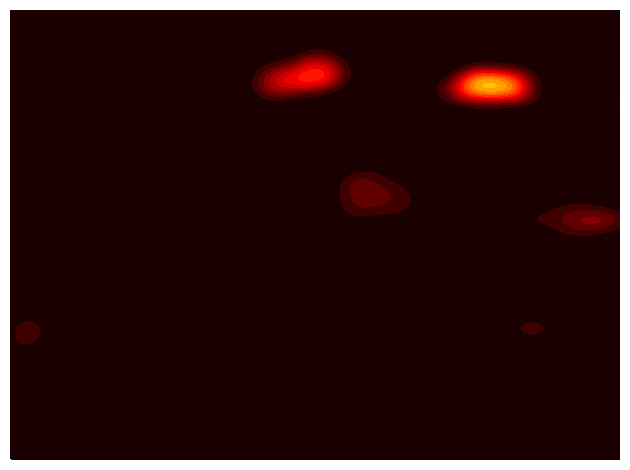

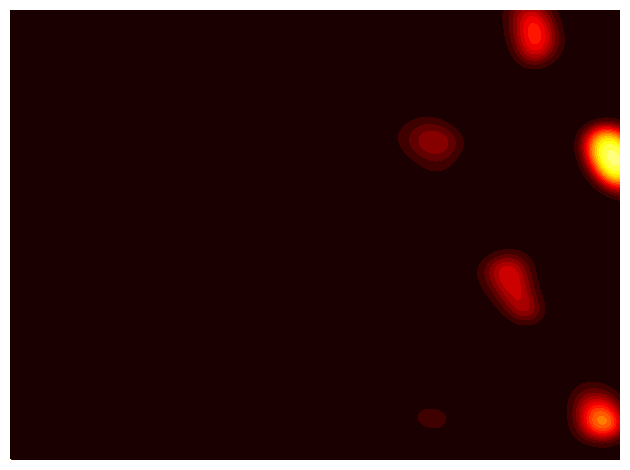

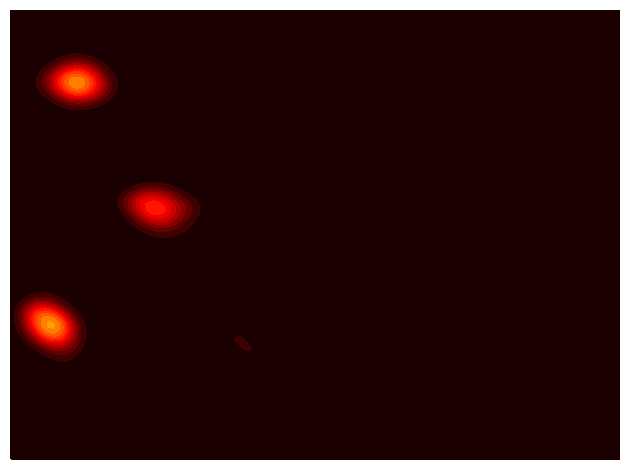

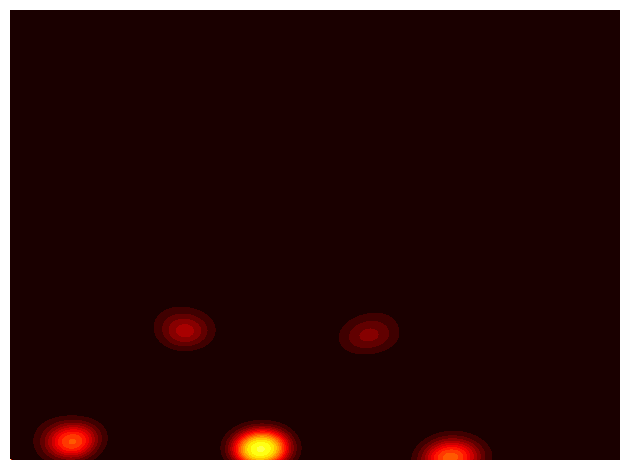

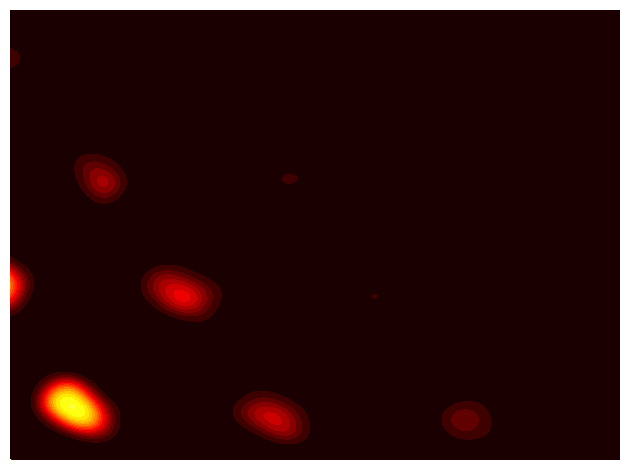

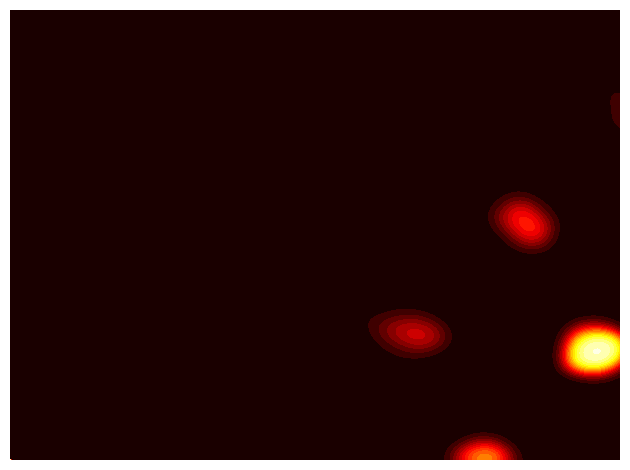

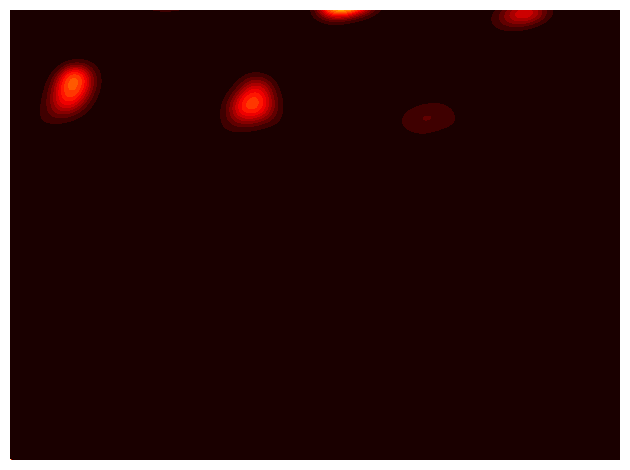

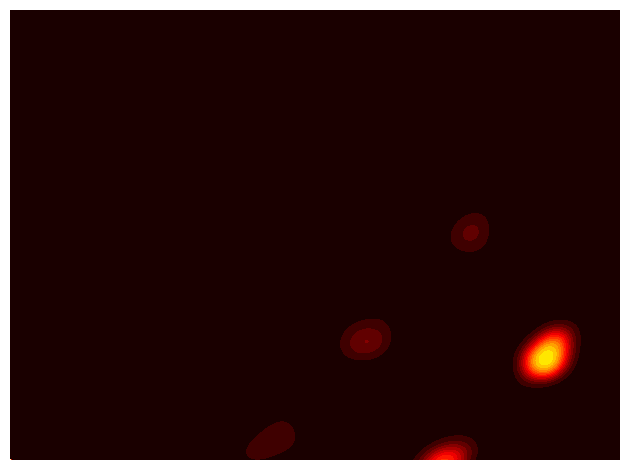

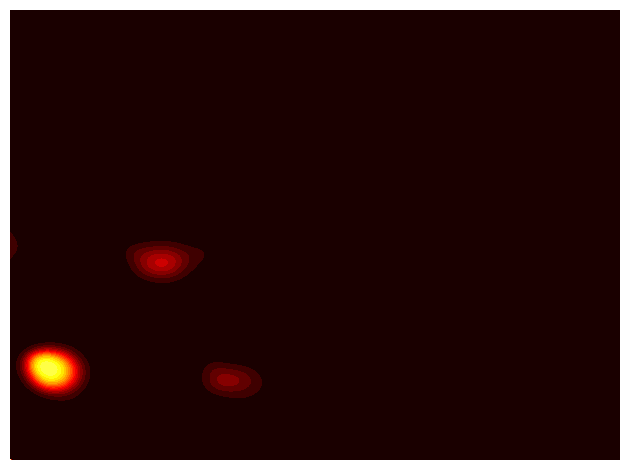

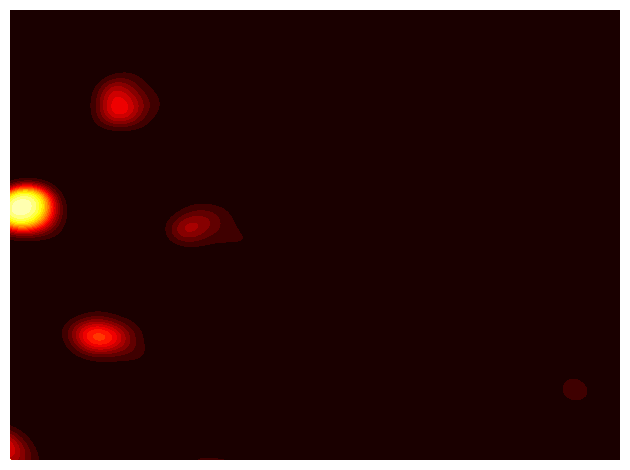

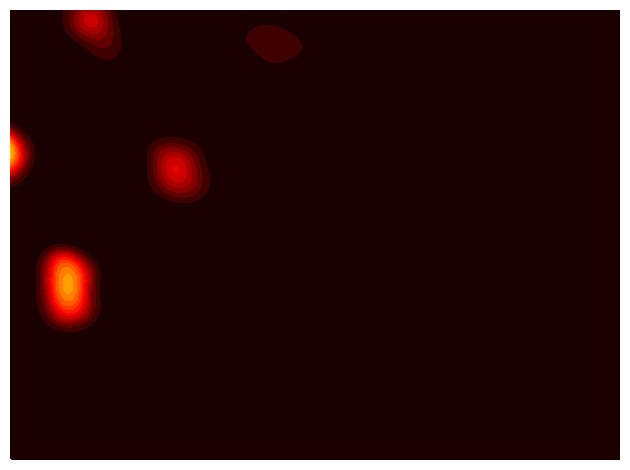

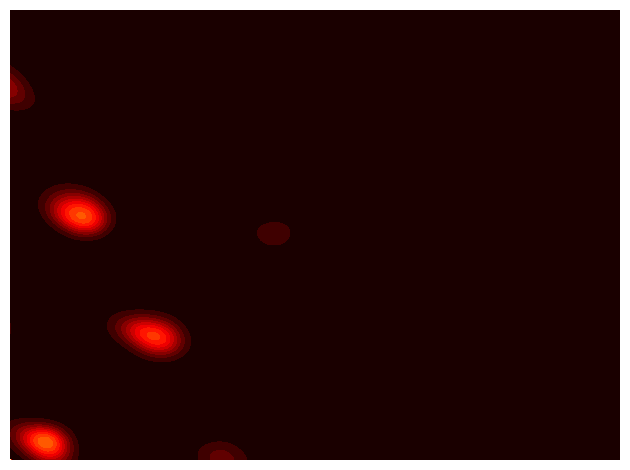

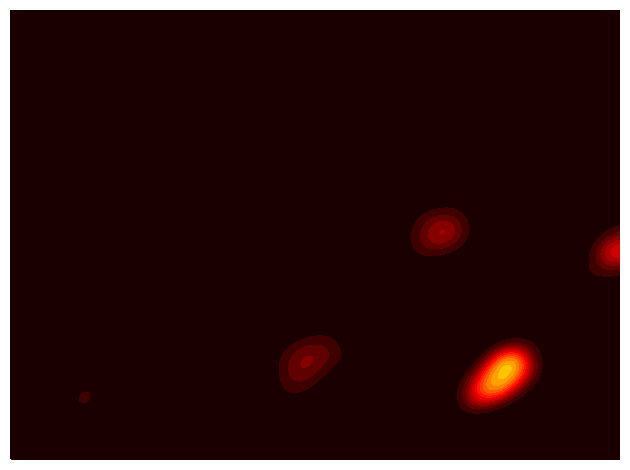

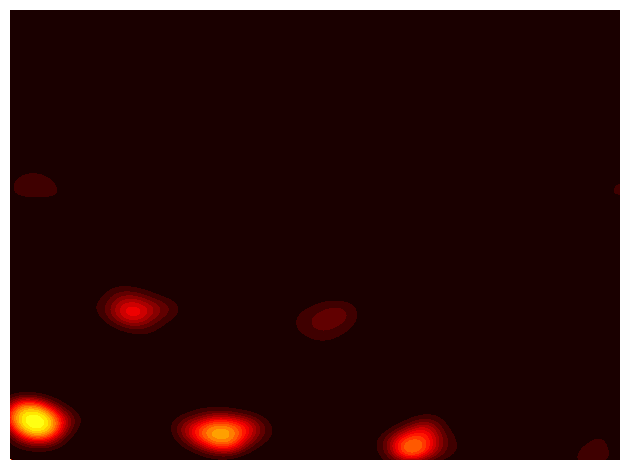

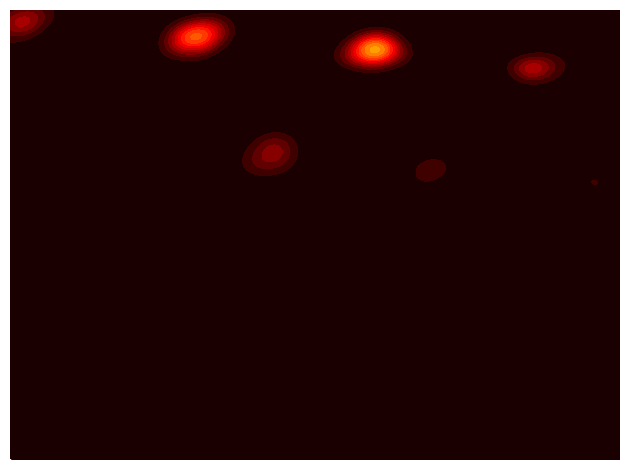

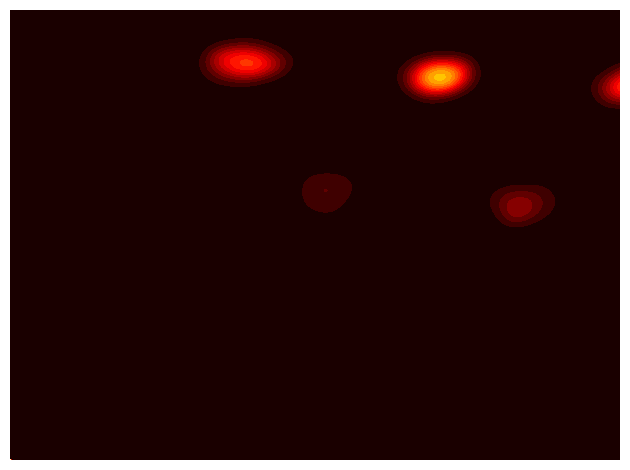

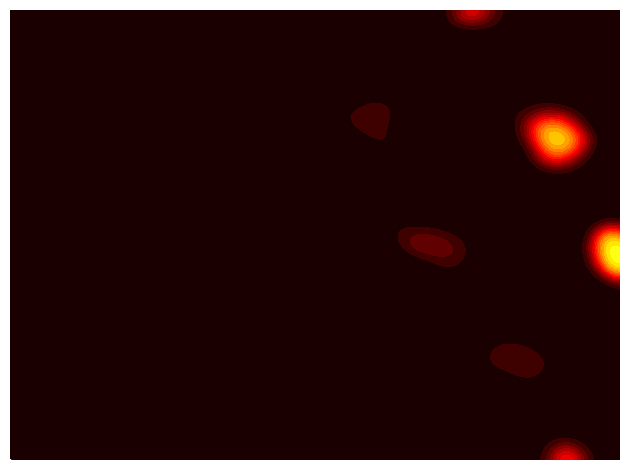

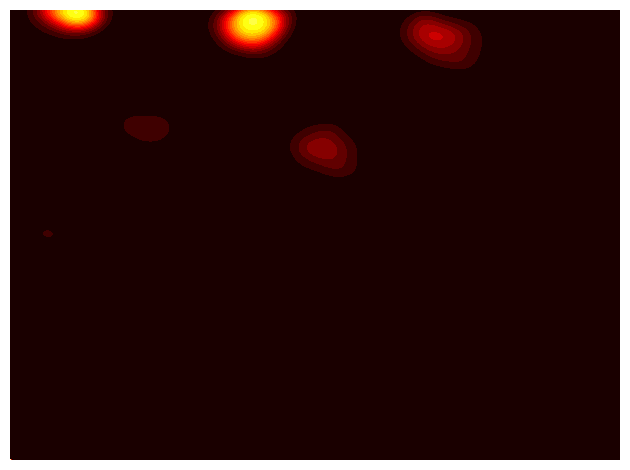

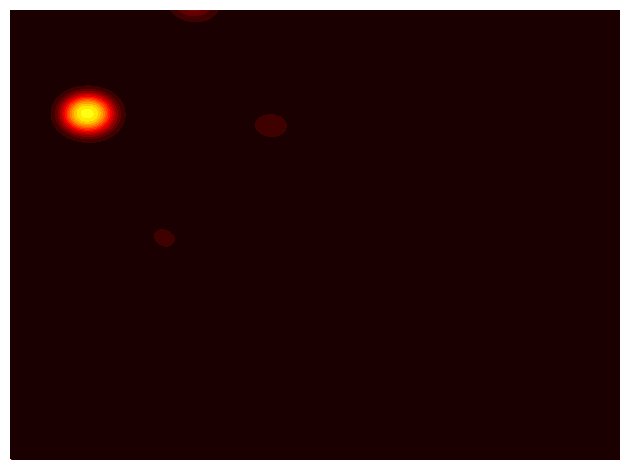

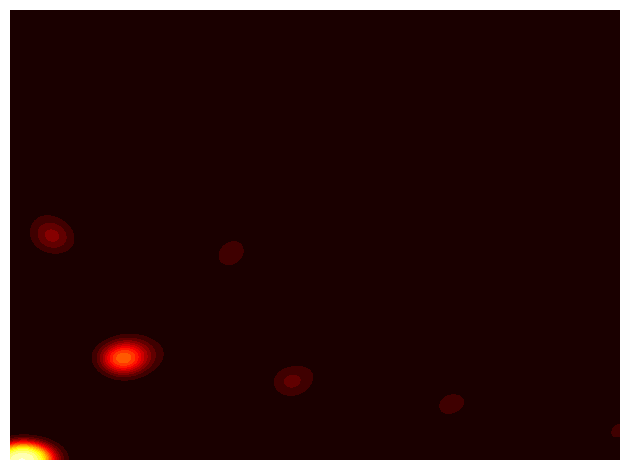

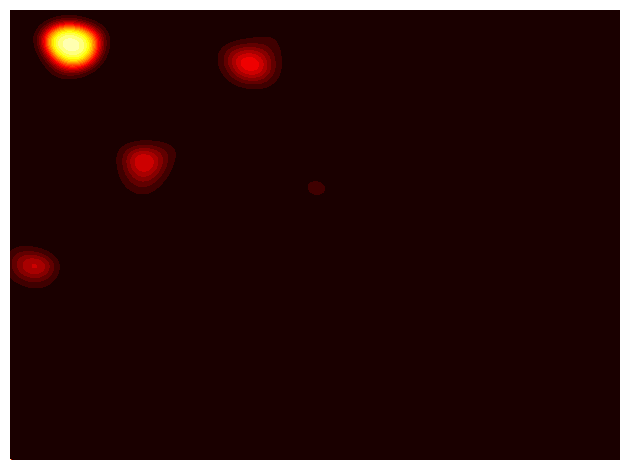

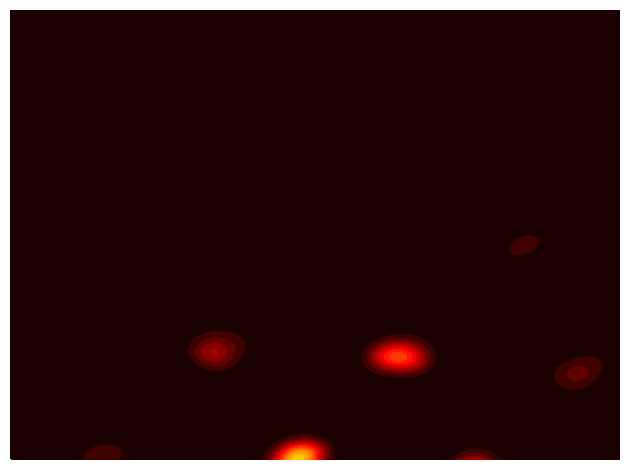

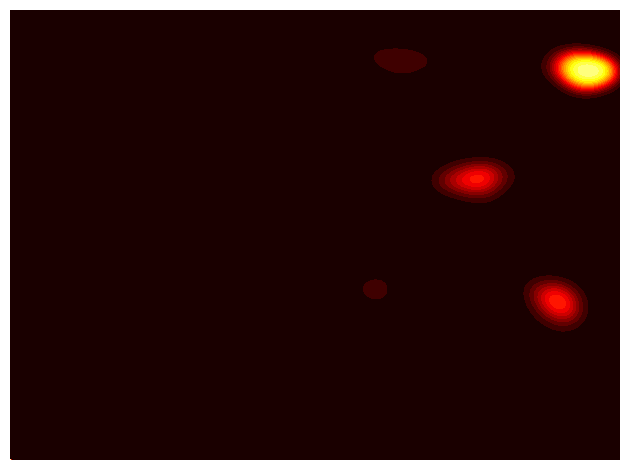

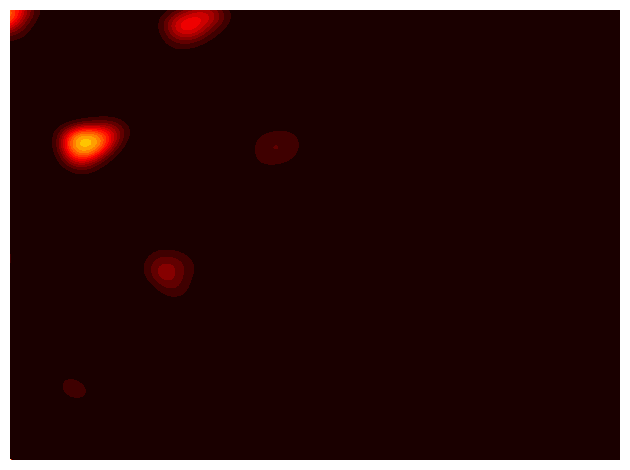

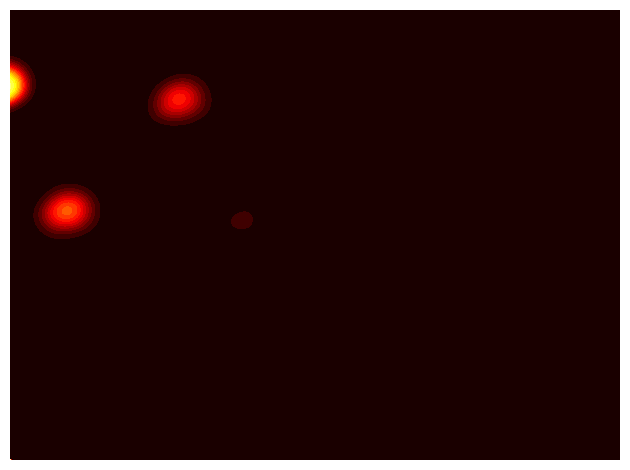

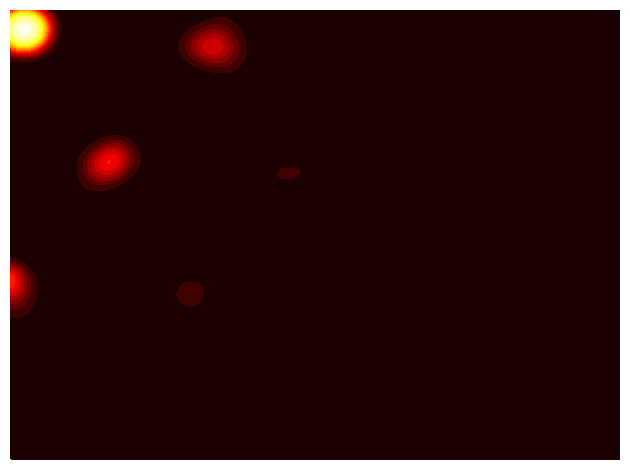

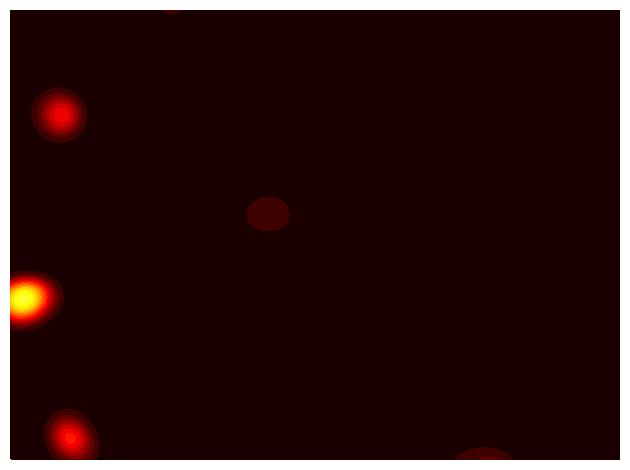

In [13]:
for img in hidden[used]:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
N = 20
epochs = 3000

flanks = get_flanks(exp.res + exp.res // 10)
targets = net.lin1(exp.grid_cells).permute(-1, 0, 1)[:N].detach()

pfs = PlaceFields(exp.coords, flanks, targets)
pfs.informed_init()
losses = pfs.fit()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:32<00:00, 32.29it/s]


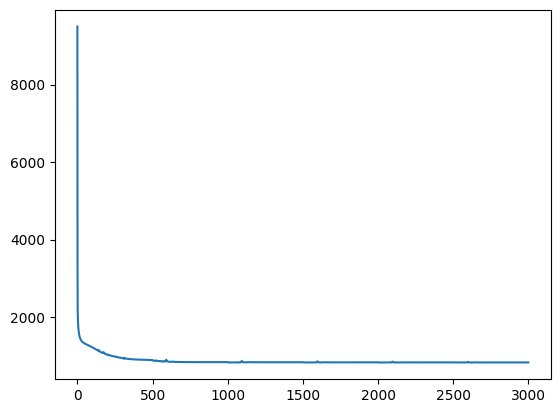

In [15]:
plt.plot(losses[:])

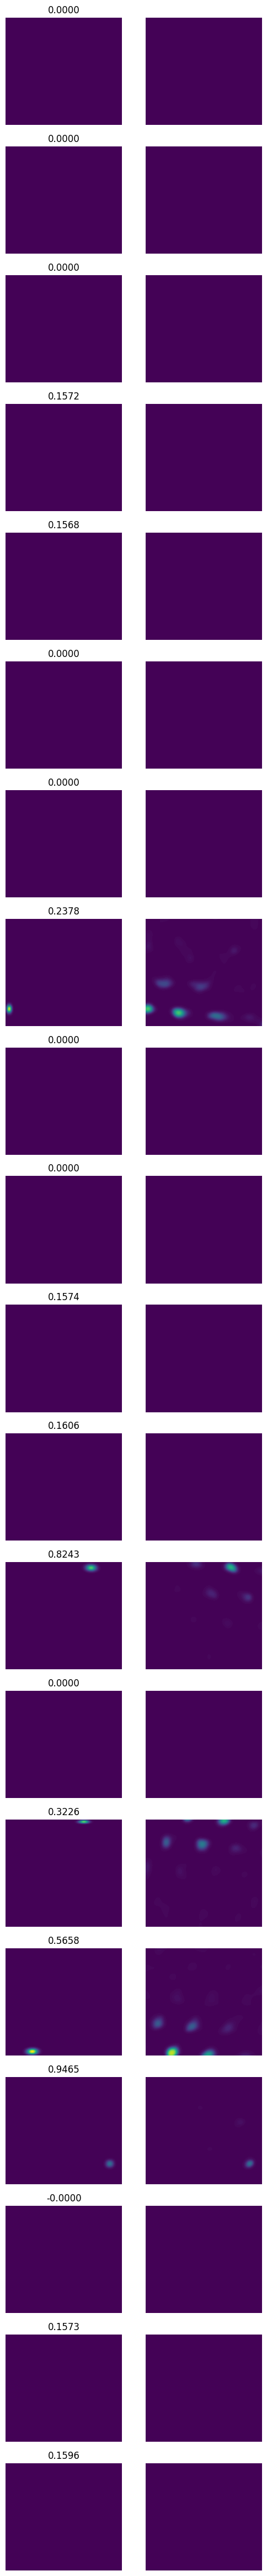

In [16]:
preds = pfs.predict().cpu().detach().numpy()
preds[:,0,0] = hidden.max()
hidden[:,0,0] = hidden.max()
explained = 1 - torch.pow(pfs.predict() - pfs.targets, 2).sum((1, 2)) / torch.pow(pfs.targets, 2).sum((1, 2))

for (ax1, ax2), pred, real, expl in zip(plt.subplots(N, 2, figsize=(6, 3*N))[1],
                                  preds, hidden[:N], explained.cpu().detach()):
    ax1.contourf(pred, levels=100)
    ax1.axis('off')
    ax1.set_title(f"{expl.item():.04f}")
    ax2.contourf(real, levels=100)
    ax2.axis('off')
plt.show()

In [17]:
exp.save()

In [18]:
t = Experiment.load_experiment('data', 'test')

In [ ]:
t.compile_grid_cells(1)

In [28]:
eval_position(t.agent, t.coords, t.grid_cells)

0.6370011